# What service problems and satisfaction levels do students report regarding the Ring Bus system, and how do these experiences vary across residence groups and service periods (weekday vs weekend)?

In [1]:
!pip install uv
!uv pip install scikit-posthocs
!uv pip install statsmodels

Traceback (most recent call last):
  File "/usr/bin/pip", line 5, in <module>
    from pip._internal.cli.main import main
ModuleNotFoundError: No module named 'pip'
Using Python 3.12.11 environment at: /home/master/Documents/competitions/cirsDataSet/.venv
Audited 1 package in 4ms
Using Python 3.12.11 environment at: /home/master/Documents/competitions/cirsDataSet/.venv
Audited 1 package in 3ms


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import wilcoxon, kruskal, chi2_contingency
from statsmodels.stats.multitest import multipletests
from scikit_posthocs import posthoc_dunn  
from statsmodels.stats.proportion import proportion_confint  

In [3]:
df = pd.read_csv('../data/metu_ring_processed.csv')

In [4]:
df.head()

,Gender,Residence,Study_Level,Faculty,Grad_School,Visiting_Faculty_GradSchool,Affiliation_Program,Weekday_Schedule_Satisfaction,Weekend_Schedule_Satisfaction,Understanding_Routes,...,TimeWkend_Afternoon_15:00_19:00,TimeWkend_Late_19:00_23:00,Total_Usage_Score,Problem_Severity_Index,Heavy_User,Residence_Simplified,Route_Count,Purpose_Count,Reason_Count,UseMore_Binary
0,Male,"East Dorms (1st Dorm, 2nd Dorm, 16th Guesthous...",Undergraduate (Bachelor’s),Faculty of Engineering,NaN,NaN,NaN,2,1,1.0,...,1,1,5,4.125,0,East_Dorms,2,3,2,1.0
1,Female,"West Dorms (Isa Demiray Student Dormitory, 19t...",Undergraduate (Bachelor’s),Faculty of Arts and Sciences,NaN,NaN,NaN,4,3,3.0,...,0,1,8,2.500,1,West_Dorms,2,6,1,1.0
2,Female,"West Dorms (Isa Demiray Student Dormitory, 19t...",Undergraduate (Bachelor’s),Faculty of Engineering,NaN,NaN,NaN,2,2,5.0,...,1,1,8,3.125,1,West_Dorms,3,5,2,1.0
3,Male,"West Dorms (Isa Demiray Student Dormitory, 19t...",Undergraduate (Bachelor’s),Faculty of Engineering,NaN,NaN,NaN,3,2,5.0,...,0,0,8,2.500,1,West_Dorms,1,2,2,1.0
4,Male,Off-campus (within walking distance),Undergraduate (Bachelor’s),Faculty of Economic and Administrative Sciences,NaN,NaN,NaN,4,3,2.0,...,0,1,5,2.250,1,Off_Campus_Near,4,4,1,1.0


In [5]:
def interpret_effect_size(effect_size, effect_type):
    """
    Interpret effect size magnitude.
    Returns interpretation string.
    """
    if effect_type == 'cramers_v':
        if effect_size < 0.1:
            return 'negligible'
        elif effect_size < 0.3:
            return 'small'
        elif effect_size < 0.5:
            return 'medium'
        else:
            return 'large'
    elif effect_type == 'epsilon_squared':
        if effect_size < 0.01:
            return 'negligible'
        elif effect_size < 0.06:
            return 'small'
        elif effect_size < 0.14:
            return 'medium'
        else:
            return 'large'
    elif effect_type == 'rank_biserial' or effect_type == 'cohens_d':
        abs_effect = abs(effect_size)
        if abs_effect < 0.2:
            return 'negligible'
        elif abs_effect < 0.5:
            return 'small'
        elif abs_effect < 0.8:
            return 'medium'
        else:
            return 'large'
    else:
        return 'unknown'

In [6]:
df['Residence'] = df['Residence'].replace(
    'Postgraduate Guesthouse', 
    'West Dorms (Isa Demiray Student Dormitory, 19th Dorm, etc.)'
)

# Create Residence_Simplified
def simplify_residence(res):
    if pd.isna(res):
        return 'Unknown'
    if 'East' in str(res):
        return 'East_Dorms'
    elif 'West' in str(res) or 'Isa Demiray' in str(res) or 'Postgrad_Guesthouse' in str(res):
        return 'West_Dorms'
    elif 'within walking' in str(res).lower():
        return 'Off_Campus_Near'
    elif 'far' in str(res).lower():
        return 'Off_Campus_Far'
    else:
        return 'Other'

if 'Residence_Simplified' not in df.columns:
    df['Residence_Simplified'] = df['Residence'].apply(simplify_residence)

# Filter to valid residence groups (n >= 10)
residence_counts = df['Residence_Simplified'].value_counts()
valid_residences = residence_counts[residence_counts >= 10].index
df = df[df['Residence_Simplified'].isin(valid_residences)].copy()

print("="*70)
print("STEP 0: Data Setup Complete")
print("="*70)
print(f"Valid residence groups: {list(valid_residences)}")
print(f"Total N: {len(df)}")

STEP 0: Data Setup Complete
Valid residence groups: ['East_Dorms', 'West_Dorms', 'Off_Campus_Far', 'Off_Campus_Near']
Total N: 323


In [7]:
# =============================================================================
# STEP 1: Clean Subgroup Definitions + Post-Stratification Weights (RAKING METHOD)
# =============================================================================
print("\n" + "="*70)
print("STEP 1: Subgroup Definitions and Post-Stratification Weights (Raking)")
print("="*70)

# 1A) Residence groups
print("\n1A) Residence Groups (n):")
print(df['Residence_Simplified'].value_counts().sort_index())

# 1B) Post-stratification using RAKING (recommended method)
# Raking adjusts weights iteratively to match marginal proportions for Gender and Study Level separately
# This avoids the independence assumption required for joint-strata weights

# Create simplified study level (Undergraduate vs Graduate)
def simplify_study_level(study_level):
    """Map study level to Undergraduate or Graduate"""
    if pd.isna(study_level):
        return 'Other'
    study_str = str(study_level).lower()
    if 'undergrad' in study_str or 'bachelor' in study_str:
        return 'Undergraduate'
    elif 'master' in study_str or 'phd' in study_str or 'doctoral' in study_str:
        return 'Graduate'
    else:
        return 'Other'

df['Study_Level_Simplified'] = df['Study_Level'].apply(simplify_study_level)

# Filter to valid strata for weighting
df_weighting = df[(df['Gender'].isin(['Female', 'Male'])) & 
                  (df['Study_Level_Simplified'].isin(['Undergraduate', 'Graduate']))].copy()

print(f"\n1B) Sample size for weighting: {len(df_weighting)}")

# =============================================================================
# POPULATION PROPORTIONS (From METU at a Glance 2024)
# Source: https://kgpo.metu.edu.tr/en/metu-glance
# =============================================================================
# 2024 Data (exact numbers from METU):
# Total Students: 23,395
# Female Students: 10,185
# Male Students: 23,395 - 10,185 = 13,210
# Undergraduate Students (Prep+Undergraduate): 18,456
# Master's Students: 2,659
# Ph.D Students: 1,887
# Graduate Total: 2,659 + 1,887 = 4,546

# Marginal population proportions
pop_gender_props = {
    'Female': 10185 / 23395,  # 0.4350
    'Male': 13210 / 23395      # 0.5650
}

pop_study_props = {
    'Undergraduate': 18456 / 23395,  # 0.7890
    'Graduate': 4546 / 23395          # 0.1944
}

# Normalize to sum to 1
pop_gender_total = sum(pop_gender_props.values())
pop_study_total = sum(pop_study_props.values())
pop_gender_props = {k: v/pop_gender_total for k, v in pop_gender_props.items()}
pop_study_props = {k: v/pop_study_total for k, v in pop_study_props.items()}

# Population targets table
print("\n1C) Population Targets Used for Weighting (METU at a Glance 2024):")
pop_targets = pd.DataFrame({
    'Category': ['Gender', 'Gender', 'Study Level', 'Study Level'],
    'Subcategory': ['Female', 'Male', 'Undergraduate', 'Graduate'],
    'Population_Count': [10185, 13210, 18456, 4546],
    'Population_Proportion': [
        pop_gender_props['Female'],
        pop_gender_props['Male'],
        pop_study_props['Undergraduate'],
        pop_study_props['Graduate']
    ]
})
print(pop_targets.round(4))

print("\n1D) Population Marginal Proportions:")
print("  Gender:")
for gender, prop in pop_gender_props.items():
    print(f"    {gender}: {prop:.4f}")
print("  Study Level:")
for study, prop in pop_study_props.items():
    print(f"    {study}: {prop:.4f}")

# Sample marginal proportions
sample_gender_props = df_weighting['Gender'].value_counts(normalize=True).to_dict()
sample_study_props = df_weighting['Study_Level_Simplified'].value_counts(normalize=True).to_dict()

print("\n1E) Sample Marginal Proportions:")
print("  Gender:")
for gender, prop in sample_gender_props.items():
    print(f"    {gender}: {prop:.4f}")
print("  Study Level:")
for study, prop in sample_study_props.items():
    print(f"    {study}: {prop:.4f}")

# =============================================================================
# RAKING ALGORITHM
# =============================================================================
def raking_weights(gender_col, study_col, pop_gender_props, pop_study_props, max_iter=50, tol=1e-6):
    """
    Iterative proportional fitting (raking) to match marginal proportions.
    
    Algorithm:
    1. Initialize weights to 1.0
    2. Adjust weights to match gender marginals
    3. Adjust weights to match study level marginals
    4. Repeat until convergence
    """
    n = len(gender_col)
    weights = np.ones(n)
    
    for iteration in range(max_iter):
        weights_old = weights.copy()
        
        # Step 1: Adjust for gender marginals
        for gender in pop_gender_props.keys():
            gender_mask = (gender_col == gender)
            current_prop = weights[gender_mask].sum() / weights.sum()
            target_prop = pop_gender_props[gender]
            if current_prop > 0:
                weights[gender_mask] *= (target_prop / current_prop)
        
        # Step 2: Adjust for study level marginals
        for study in pop_study_props.keys():
            study_mask = (study_col == study)
            current_prop = weights[study_mask].sum() / weights.sum()
            target_prop = pop_study_props[study]
            if current_prop > 0:
                weights[study_mask] *= (target_prop / current_prop)
        
        # Check convergence
        if np.max(np.abs(weights - weights_old)) < tol:
            break
    
    # Normalize weights to sum to N (preserve sample size)
    weights = weights * n / weights.sum()
    
    return weights, iteration + 1

# Apply raking
df_weighting['Weight'], n_iter = raking_weights(
    df_weighting['Gender'],
    df_weighting['Study_Level_Simplified'],
    pop_gender_props,
    pop_study_props,
    max_iter=50,
    tol=1e-6
)

print(f"\n1F) Raking Algorithm:")
print(f"  Converged in {n_iter} iterations")
print(f"  Mean weight: {df_weighting['Weight'].mean():.3f}")
print(f"  Min weight: {df_weighting['Weight'].min():.3f}")
print(f"  Max weight: {df_weighting['Weight'].max():.3f}")
print(f"  Weight range: {df_weighting['Weight'].max() / df_weighting['Weight'].min():.2f}x")

# Verify raking worked: check weighted marginals
print("\n1G) Weighted Sample Marginals (should match population):")
weighted_gender_props = {}
for gender in pop_gender_props.keys():
    gender_mask = (df_weighting['Gender'] == gender)
    weighted_gender_props[gender] = df_weighting.loc[gender_mask, 'Weight'].sum() / df_weighting['Weight'].sum()

weighted_study_props = {}
for study in pop_study_props.keys():
    study_mask = (df_weighting['Study_Level_Simplified'] == study)
    weighted_study_props[study] = df_weighting.loc[study_mask, 'Weight'].sum() / df_weighting['Weight'].sum()

print("  Gender (weighted):")
for gender in pop_gender_props.keys():
    diff = abs(weighted_gender_props[gender] - pop_gender_props[gender])
    print(f"    {gender}: {weighted_gender_props[gender]:.4f} (target: {pop_gender_props[gender]:.4f}, diff: {diff:.4f})")
print("  Study Level (weighted):")
for study in pop_study_props.keys():
    diff = abs(weighted_study_props[study] - pop_study_props[study])
    print(f"    {study}: {weighted_study_props[study]:.4f} (target: {pop_study_props[study]:.4f}, diff: {diff:.4f})")

# Create Stratum column for stratified bootstrap (gender × study level)
df_weighting['Stratum'] = (df_weighting['Gender'].astype(str) + ' × ' + 
                           df_weighting['Study_Level_Simplified'].astype(str))

# Merge weights and stratum back to main dataframe
df = df.merge(df_weighting[['Weight', 'Stratum']], left_index=True, right_index=True, how='left')
# For rows not in weighting sample, set weight to 1.0 and stratum to 'Other'
df['Weight'] = df['Weight'].fillna(1.0)
df['Stratum'] = df['Stratum'].fillna('Other')

print("\n1H) Weight Summary:")
print(f"  Total N: {len(df)}")
print(f"  N with weights: {(df['Weight'] != 1.0).sum()}")
print(f"  N without weights (Other): {(df['Weight'] == 1.0).sum()}")
print("\nNote: Raking matches marginal proportions for Gender and Study Level separately,")
print("      avoiding the independence assumption required for joint-strata weights.")
print("      Source: METU at a Glance 2024 (https://kgpo.metu.edu.tr/en/metu-glance)")


STEP 1: Subgroup Definitions and Post-Stratification Weights (Raking)

1A) Residence Groups (n):
Residence_Simplified
East_Dorms         138
Off_Campus_Far      56
Off_Campus_Near     14
West_Dorms         115
Name: count, dtype: int64

1B) Sample size for weighting: 305

1C) Population Targets Used for Weighting (METU at a Glance 2024):
      Category    Subcategory  Population_Count  Population_Proportion
0       Gender         Female             10185                 0.4353
1       Gender           Male             13210                 0.5647
2  Study Level  Undergraduate             18456                 0.8024
3  Study Level       Graduate              4546                 0.1976

1D) Population Marginal Proportions:
  Gender:
    Female: 0.4353
    Male: 0.5647
  Study Level:
    Undergraduate: 0.8024
    Graduate: 0.1976

1E) Sample Marginal Proportions:
  Gender:
    Female: 0.5672
    Male: 0.4328
  Study Level:
    Undergraduate: 0.9246
    Graduate: 0.0754

1F) Raking Algo

In [8]:
# =============================================================================
# COLOR PALETTE SETUP - For Clear and Understandable Graphs
# =============================================================================

# Set matplotlib style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

# =============================================================================
# SEMANTIC COLOR PALETTES (Colorblind-Friendly)
# =============================================================================

# 1. SATISFACTION SCALE (Diverging: Red → Yellow → Green)
#    Red = Dissatisfied, Yellow = Neutral, Green = Satisfied
SATISFACTION_COLORS = {
    'Very Dissatisfied': '#D73027',  # Dark red
    'Dissatisfied': '#F46D43',       # Orange-red
    'Neutral': '#FEE08B',            # Light yellow
    'Satisfied': '#ABDDA4',          # Light green
    'Very Satisfied': '#66C2A5'      # Teal-green
}
SATISFACTION_PALETTE = ['#D73027', '#F46D43', '#FEE08B', '#ABDDA4', '#66C2A5']

# 2. WEEKDAY vs WEEKEND (Complementary colors)
WEEKDAY_COLOR = '#2E86AB'  # Blue (professional, weekday)
WEEKEND_COLOR = '#A23B72'  # Purple (leisure, weekend)
WEEKDAY_WEEKEND_PALETTE = [WEEKDAY_COLOR, WEEKEND_COLOR]

# 3. RESIDENCE GROUPS (Distinct, high contrast)
RESIDENCE_COLORS = {
    'East_Dorms': '#E07A5F',      # Coral/Orange-red
    'West_Dorms': '#3D5A80',      # Deep blue
    'Off_Campus_Near': '#81B29A', # Sage green
    'Off_Campus_Far': '#F2CC8F'   # Warm yellow
}
RESIDENCE_PALETTE = [RESIDENCE_COLORS.get(r, '#95A5A6') for r in sorted(RESIDENCE_COLORS.keys())]

# 4. PROBLEMS (Red scale - severity)
PROBLEM_COLORS = {
    'Too Crowded': '#C1121F',      # Dark red (most severe)
    'Long Wait': '#E63946',        # Bright red
    'Late Bus': '#F77F00',         # Orange
    'Hours Mismatch': '#FCBF49',   # Yellow-orange
    'Not My Route': '#F1C40F',     # Yellow
    'Route Confusing': '#E67E22', # Orange
    'Not Clean': '#95A5A6',        # Gray
    'Driver Behavior': '#7F8C8D'   # Dark gray
}
PROBLEM_PALETTE = ['#C1121F', '#E63946', '#F77F00', '#FCBF49', '#F1C40F', '#E67E22', '#95A5A6', '#7F8C8D']

# 5. FREQUENCY SCALE (Sequential: Light → Dark)
FREQUENCY_COLORS = {
    'Never': '#F7F7F7',        # Very light gray
    'Rarely': '#D9D9D9',      # Light gray
    'Sometimes': '#969696',   # Medium gray
    'Often': '#525252',       # Dark gray
    'Always': '#252525'       # Very dark gray
}
FREQUENCY_PALETTE = ['#F7F7F7', '#D9D9D9', '#969696', '#525252', '#252525']

# 6. GENDER (Distinct, accessible)
GENDER_COLORS = {
    'Male': '#3498DB',        # Blue
    'Female': '#E91E63',      # Pink/Magenta
    'Other': '#9B59B6'        # Purple
}
GENDER_PALETTE = ['#3498DB', '#E91E63', '#9B59B6']

# 7. STUDY LEVEL (Sequential, distinct)
STUDY_LEVEL_COLORS = {
    'Undergraduate': '#3498DB',  # Blue
    'Master': '#2ECC71',         # Green
    'PhD': '#E74C3C'             # Red
}
STUDY_LEVEL_PALETTE = ['#3498DB', '#2ECC71', '#E74C3C']

# 8. BINARY/COMPARISON (High contrast)
BINARY_COLORS = {
    'Yes': '#27AE60',         # Green
    'No': '#E74C3C',          # Red
    'Not Sure': '#F39C12'     # Orange
}
BINARY_PALETTE = ['#27AE60', '#E74C3C', '#F39C12']

# 9. POSITIVE vs NEGATIVE (Diverging)
POSITIVE_COLOR = '#27AE60'    # Green
NEGATIVE_COLOR = '#E74C3C'    # Red
NEUTRAL_COLOR = '#F39C12'     # Orange

# 10. MULTI-CATEGORY (Distinct, colorblind-friendly)
#     Using ColorBrewer Set2 palette (8 colors, colorblind-safe)
MULTI_CATEGORY_PALETTE = [
    '#66C2A5',  # Teal
    '#FC8D62',  # Orange
    '#8DA0CB',  # Blue
    '#E78AC3',  # Pink
    '#A6D854',  # Green
    '#FFD92F',  # Yellow
    '#E5C494',  # Tan
    '#B3B3B3'   # Gray
]

# =============================================================================
# HELPER FUNCTIONS
# =============================================================================

def get_residence_color(residence):
    """Get color for a residence group"""
    return RESIDENCE_COLORS.get(residence, '#95A5A6')

def get_problem_color(problem):
    """Get color for a problem (by severity)"""
    return PROBLEM_COLORS.get(problem, '#95A5A6')

def apply_colorblind_friendly_palette(n_colors):
    """Generate colorblind-friendly palette for n colors"""
    if n_colors <= 8:
        return MULTI_CATEGORY_PALETTE[:n_colors]
    elif n_colors <= 10:
        # Use ColorBrewer Set3
        return sns.color_palette("Set3", n_colors)
    else:
        # Use ColorBrewer Set2 + Set3
        return sns.color_palette("Set2", n_colors)

def create_diverging_palette(center_color='#FEE08B', n_colors=5):
    """Create diverging palette (red → center → green)"""
    if n_colors == 5:
        return SATISFACTION_PALETTE
    else:
        return sns.diverging_palette(10, 150, s=80, l=55, n=n_colors, center='light')

# =============================================================================
# PLOT-SPECIFIC COLOR SETTINGS
# =============================================================================

# Boxplot settings
BOXPLOT_COLORS = {
    'box': '#3498DB',
    'median': '#E74C3C',
    'whisker': '#34495E',
    'outlier': '#E74C3C'
}

# Error bar settings
ERROR_BAR_COLOR = '#2C3E50'
ERROR_BAR_CAP_SIZE = 5

# Grid settings
GRID_COLOR = '#ECF0F1'
GRID_ALPHA = 0.3

# Text colors
TEXT_COLOR = '#2C3E50'
TITLE_COLOR = '#1A1A1A'

In [9]:
def epsilon_squared(x, y):
    """
    Calculate epsilon-squared (effect size for Kruskal-Wallis).
    Epsilon-squared = (H - k + 1) / (n - k)
    where H is Kruskal-Wallis statistic, k is number of groups, n is total sample size
    """
    h_stat, _ = kruskal(*[group for group in [x, y] if len(group) > 0])
    n = sum(len(group) for group in [x, y])
    k = len([group for group in [x, y] if len(group) > 0])
    return (h_stat - k + 1) / (n - k) if n > k else 0

def cliffs_delta(x, y):
    """
    Calculate Cliff's delta (effect size for nonparametric comparisons).
    Returns value between -1 and 1:
    -1: all values in x are greater than all values in y
     0: distributions are identical
     1: all values in y are greater than all values in x
    """
    x, y = np.array(x), np.array(y)
    n_x, n_y = len(x), len(y)
    dominance = sum(sum(x_i > y_j for y_j in y) - sum(x_i < y_j for y_j in y) 
                    for x_i in x)
    return dominance / (n_x * n_y)

def bootstrap_median_ci(data, weights=None, n_bootstrap=5000, confidence=0.95):
    """
    Bootstrap CI for median (improved for discrete data).
    Uses more samples and handles ties better.
    """
    n = len(data)
    bootstrapped_medians = []
    
    # Convert to numpy array for easier handling
    if isinstance(data, pd.Series):
        data_array = data.values
    else:
        data_array = np.array(data)
    
    for _ in range(n_bootstrap):
        if weights is not None:
            # Weighted bootstrap
            indices = np.random.choice(n, size=n, replace=True, 
                                      p=np.array(weights)/np.array(weights).sum())
            sample = data_array[indices]
            sample_weights = np.array(weights)[indices] if isinstance(weights, pd.Series) else np.array(weights)[indices]
            # For weighted median, use percentile
            bootstrapped_medians.append(np.average(sample, weights=sample_weights))
        else:
            # Simple bootstrap
            sample = np.random.choice(data_array, size=n, replace=True)
            bootstrapped_medians.append(np.median(sample))
    
    bootstrapped_medians = np.array(bootstrapped_medians)
    alpha = 1 - confidence
    
    # Use interpolation method for better handling of discrete data
    lower = np.percentile(bootstrapped_medians, 100 * alpha/2, method='linear')
    upper = np.percentile(bootstrapped_medians, 100 * (1 - alpha/2), method='linear')
    
    # For discrete data, round to nearest observed value if CI is too narrow
    unique_values = np.unique(data_array)
    if upper - lower < 0.1 and len(unique_values) > 1:
        # If CI is degenerate, use IQR-based approach
        q25_actual = np.percentile(data_array, 25)
        q75_actual = np.percentile(data_array, 75)
        median_actual = np.median(data_array)
        # Use IQR to estimate uncertainty
        iqr = q75_actual - q25_actual
        se_approx = 1.25 * iqr / np.sqrt(n)  # Approximate SE for median
        lower = max(unique_values[0], median_actual - 1.96 * se_approx)
        upper = min(unique_values[-1], median_actual + 1.96 * se_approx)
        # Round to nearest observed value
        lower = unique_values[np.argmin(np.abs(unique_values - lower))]
        upper = unique_values[np.argmin(np.abs(unique_values - upper))]
    
    return lower, upper

def stratified_bootstrap_ci(data, weights, strata, n_bootstrap=1000, confidence=0.95):
    """
    Stratified bootstrap CI (by weighting strata).
    Resamples within each stratum, then recomputes weighted estimate.
    """
    bootstrapped_estimates = []
    
    for _ in range(n_bootstrap):
        # Resample within each stratum
        resampled_indices = []
        for stratum in strata.unique():
            stratum_mask = (strata == stratum)
            stratum_indices = data[stratum_mask].index
            n_stratum = len(stratum_indices)
            # Bootstrap within stratum
            boot_indices = np.random.choice(stratum_indices, size=n_stratum, replace=True)
            resampled_indices.extend(boot_indices)
        
        # Compute weighted estimate on resampled data
        resampled_data = data.loc[resampled_indices]
        resampled_weights = weights.loc[resampled_indices]
        estimate = np.average(resampled_data, weights=resampled_weights)
        bootstrapped_estimates.append(estimate)
    
    alpha = 1 - confidence
    lower = np.percentile(bootstrapped_estimates, 100 * alpha/2)
    upper = np.percentile(bootstrapped_estimates, 100 * (1 - alpha/2))
    return lower, upper

print("Nonparametric statistical functions loaded!")

Nonparametric statistical functions loaded!



STEP 2: Satisfaction - Weekday vs Weekend (Nonparametric Analysis)

2A) Nonparametric Statistics:
  Weekday satisfaction - Median: 3.00
  Weekend satisfaction - Median: 2.00
  Satisfaction gap - Median: 1.00 (IQR: [0.00, 2.00])
  Hodges-Lehmann estimate: 1.00
  Median gap 95% CI (bootstrap): [1.00, 1.00]

2B) Wilcoxon Signed-Rank Test (PRIMARY):
  W-statistic: 2978.000
  p-value: 0.000000
  Rank-biserial correlation (effect size): -0.575
  Interpretation: Significant difference

2C) Paired t-test (ROBUSTNESS CHECK):
  t-statistic: 12.918
  p-value: 0.000000
  Cohen's d: 0.719
  Note: Reported as secondary check; primary analysis uses nonparametric test


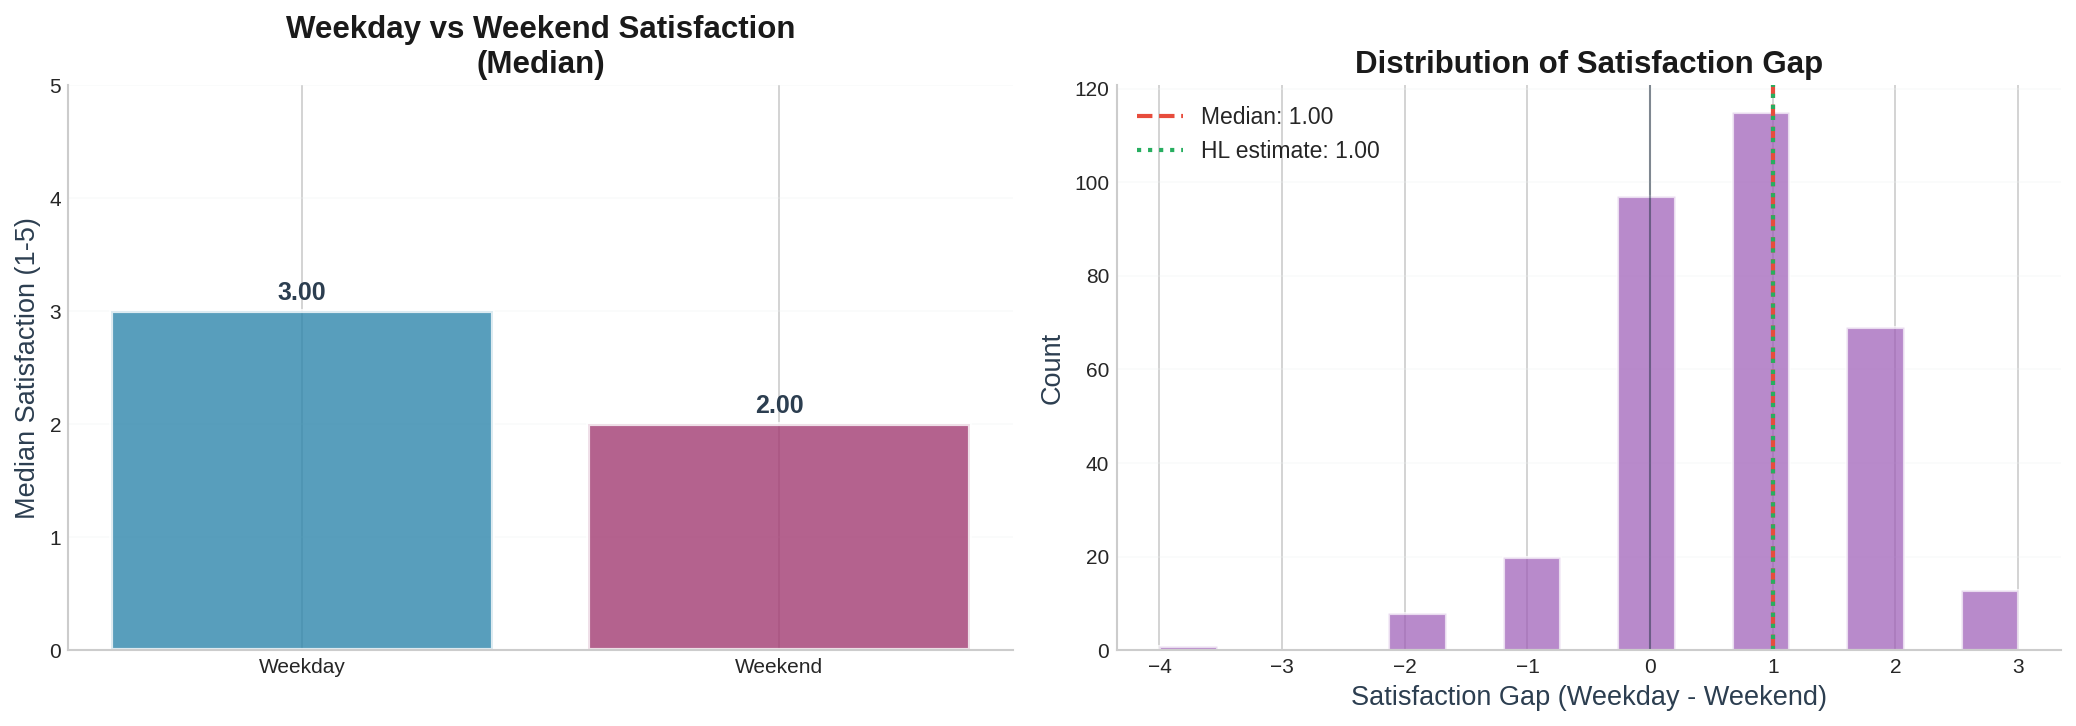

In [10]:
# =============================================================================
# STEP 2: Satisfaction - Weekday vs Weekend (NONPARAMETRIC)
# =============================================================================
print("\n" + "="*70)
print("STEP 2: Satisfaction - Weekday vs Weekend (Nonparametric Analysis)")
print("="*70)

# Create satisfaction gap
df['Satisfaction_Gap'] = df['Weekday_Schedule_Satisfaction'] - df['Weekend_Schedule_Satisfaction']

# Get paired data
paired_data = df[['Weekday_Schedule_Satisfaction', 'Weekend_Schedule_Satisfaction', 
                  'Satisfaction_Gap']].dropna()
n_paired = len(paired_data)

# NONPARAMETRIC STATISTICS
# Median and quartiles
median_wd = paired_data['Weekday_Schedule_Satisfaction'].median()
median_we = paired_data['Weekend_Schedule_Satisfaction'].median()
median_gap = paired_data['Satisfaction_Gap'].median()
q25_gap = paired_data['Satisfaction_Gap'].quantile(0.25)
q75_gap = paired_data['Satisfaction_Gap'].quantile(0.75)

# Hodges-Lehmann estimate (median of all pairwise differences)
wd_values = paired_data['Weekday_Schedule_Satisfaction'].values
we_values = paired_data['Weekend_Schedule_Satisfaction'].values
pairwise_diffs = np.array([w - e for w in wd_values for e in we_values])
hl_estimate = np.median(pairwise_diffs)

# Bootstrap CI for median gap
median_gap_ci = bootstrap_median_ci(paired_data['Satisfaction_Gap'], n_bootstrap=1000)

print("\n2A) Nonparametric Statistics:")
print(f"  Weekday satisfaction - Median: {median_wd:.2f}")
print(f"  Weekend satisfaction - Median: {median_we:.2f}")
print(f"  Satisfaction gap - Median: {median_gap:.2f} (IQR: [{q25_gap:.2f}, {q75_gap:.2f}])")
print(f"  Hodges-Lehmann estimate: {hl_estimate:.2f}")
print(f"  Median gap 95% CI (bootstrap): [{median_gap_ci[0]:.2f}, {median_gap_ci[1]:.2f}]")

# PRIMARY TEST: Wilcoxon signed-rank
w_stat, p_wilcoxon = wilcoxon(
    paired_data['Weekday_Schedule_Satisfaction'],
    paired_data['Weekend_Schedule_Satisfaction'],
    alternative='two-sided'
)

# Effect size: rank-biserial correlation (for Wilcoxon)
# r = 1 - (2*W) / (n*(n+1)) where W is sum of signed ranks
# Approximate using z-score
z_wilcoxon = stats.norm.ppf(p_wilcoxon / 2) if p_wilcoxon < 1 else 0
r_rank_biserial = z_wilcoxon / np.sqrt(n_paired)

print("\n2B) Wilcoxon Signed-Rank Test (PRIMARY):")
print(f"  W-statistic: {w_stat:.3f}")
print(f"  p-value: {p_wilcoxon:.6f}")
print(f"  Rank-biserial correlation (effect size): {r_rank_biserial:.3f}")
print(f"  Interpretation: {'Significant' if p_wilcoxon < 0.05 else 'Not significant'} difference")

# ROBUSTNESS CHECK: Paired t-test (secondary)
t_stat, p_ttest = stats.ttest_rel(
    paired_data['Weekday_Schedule_Satisfaction'],
    paired_data['Weekend_Schedule_Satisfaction']
)
cohens_d = paired_data['Satisfaction_Gap'].mean() / paired_data['Satisfaction_Gap'].std()

print("\n2C) Paired t-test (ROBUSTNESS CHECK):")
print(f"  t-statistic: {t_stat:.3f}")
print(f"  p-value: {p_ttest:.6f}")
print(f"  Cohen's d: {cohens_d:.3f}")
print(f"  Note: Reported as secondary check; primary analysis uses nonparametric test")

# Plot: Weekday vs Weekend (with medians)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Median satisfaction comparison
ax1 = axes[0]
medians = [median_wd, median_we]
labels = ['Weekday', 'Weekend']
colors = WEEKDAY_WEEKEND_PALETTE

bars = ax1.bar(labels, medians, color=colors, edgecolor='white', linewidth=2, alpha=0.8)
for i, (median, label) in enumerate(zip(medians, labels)):
    ax1.text(i, median + 0.1, f'{median:.2f}', 
             ha='center', fontsize=12, fontweight='bold', color=TEXT_COLOR)

ax1.set_ylabel('Median Satisfaction (1-5)', fontsize=13, color=TEXT_COLOR)
ax1.set_title('Weekday vs Weekend Satisfaction\n(Median)', 
              fontweight='bold', fontsize=15, color=TITLE_COLOR)
ax1.set_ylim(0, 5)
ax1.grid(axis='y', alpha=GRID_ALPHA, color=GRID_COLOR)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Plot 2: Satisfaction gap distribution (with median)
ax2 = axes[1]
gap_data = paired_data['Satisfaction_Gap']
ax2.hist(gap_data, bins=15, color='#9B59B6', edgecolor='white', alpha=0.7, linewidth=1.5)
ax2.axvline(median_gap, color=NEGATIVE_COLOR, linestyle='--', linewidth=2, 
            label=f'Median: {median_gap:.2f}')
ax2.axvline(hl_estimate, color=POSITIVE_COLOR, linestyle=':', linewidth=2, 
            label=f'HL estimate: {hl_estimate:.2f}')
ax2.axvline(0, color=TEXT_COLOR, linestyle='-', linewidth=1, alpha=0.5)
ax2.set_xlabel('Satisfaction Gap (Weekday - Weekend)', fontsize=13, color=TEXT_COLOR)
ax2.set_ylabel('Count', fontsize=13, color=TEXT_COLOR)
ax2.set_title('Distribution of Satisfaction Gap', fontweight='bold', fontsize=15, color=TITLE_COLOR)
ax2.legend(fontsize=11, framealpha=0.9)
ax2.grid(axis='y', alpha=GRID_ALPHA, color=GRID_COLOR)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()
plt.close()


STEP 2B: Full Likert Distribution - Weekday vs Weekend Satisfaction


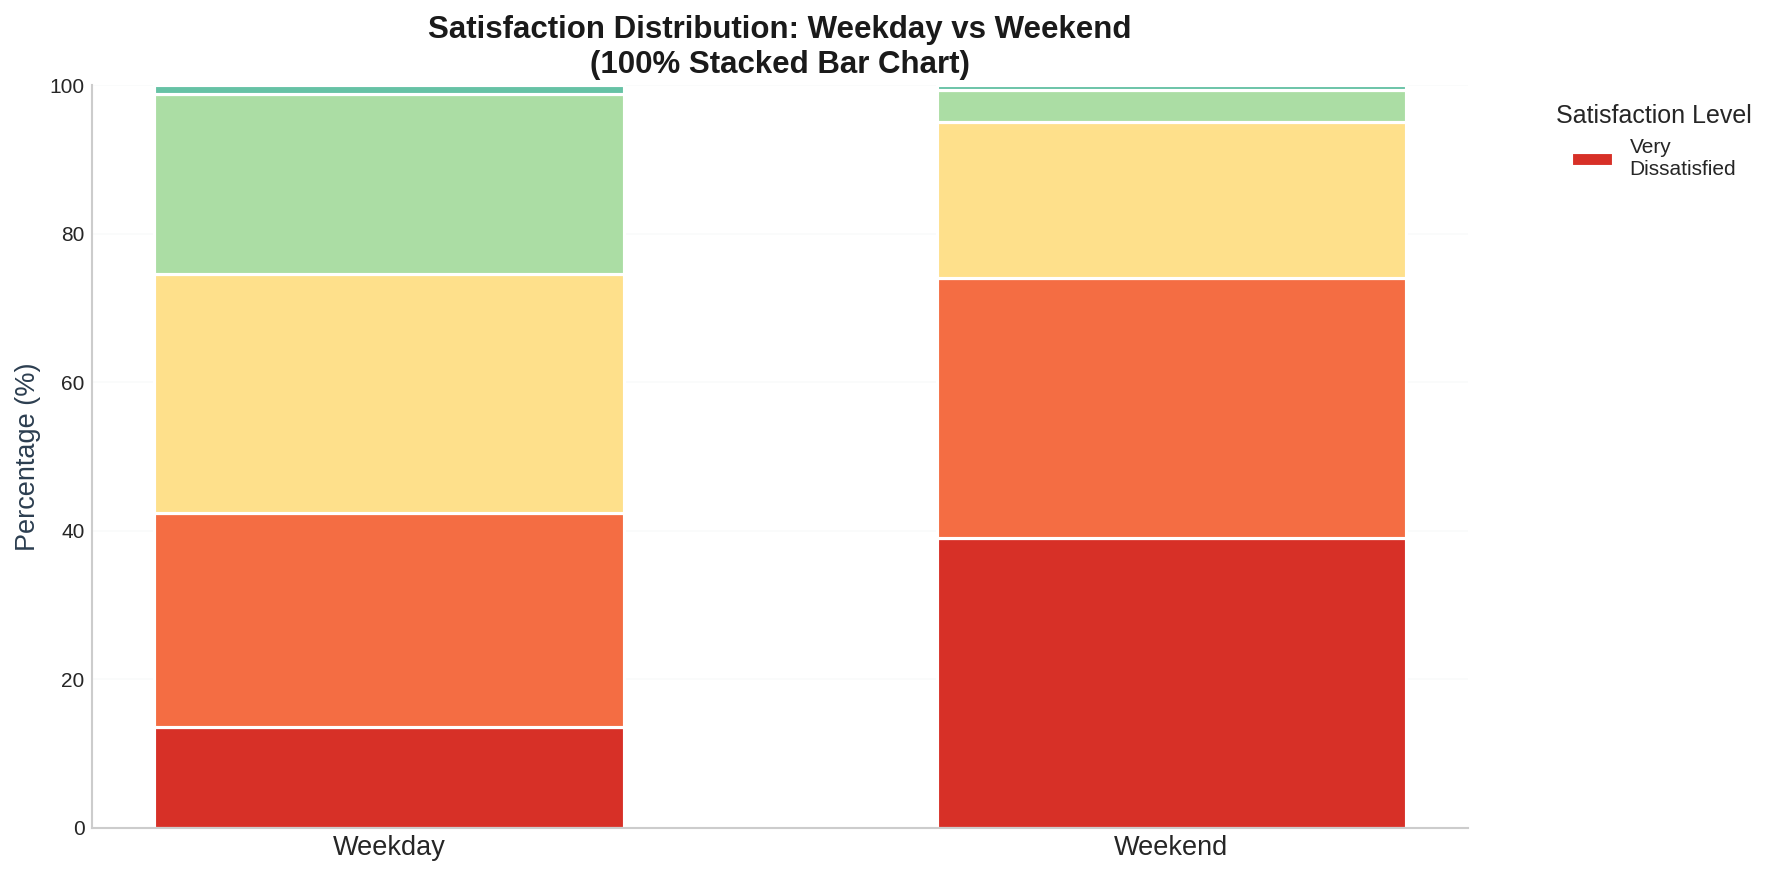

In [11]:
# =============================================================================
# STEP 2B: Stacked Likert Bar Charts (Full Distribution)
# =============================================================================
print("\n" + "="*70)
print("STEP 2B: Full Likert Distribution - Weekday vs Weekend Satisfaction")
print("="*70)

# Create satisfaction gap
df['Satisfaction_Gap'] = df['Weekday_Schedule_Satisfaction'] - df['Weekend_Schedule_Satisfaction']

# Get paired data
paired_data = df[['Weekday_Schedule_Satisfaction', 'Weekend_Schedule_Satisfaction']].dropna()
n_paired = len(paired_data)

# Create stacked data for Likert distributions
def get_likert_distribution(data, col_name):
    """Get distribution of Likert responses (1-5)"""
    counts = data[col_name].value_counts().sort_index()
    total = counts.sum()
    dist = {}
    for i in range(1, 6):
        dist[i] = counts.get(i, 0) / total * 100
    return dist

weekday_dist = get_likert_distribution(paired_data, 'Weekday_Schedule_Satisfaction')
weekend_dist = get_likert_distribution(paired_data, 'Weekend_Schedule_Satisfaction')

# Plot: Stacked Likert bar chart
fig, ax = plt.subplots(figsize=(12, 6))

categories = ['Very\nDissatisfied', 'Dissatisfied', 'Neutral', 'Satisfied', 'Very\nSatisfied']
colors_likert = SATISFACTION_PALETTE
x_pos = np.arange(2)  # Weekday and Weekend
width = 0.6

# Build stacked bars
bottom_weekday = np.zeros(2)
bottom_weekend = np.zeros(2)

for i, (cat, color) in enumerate(zip(categories, colors_likert)):
    val = i + 1
    weekday_val = weekday_dist.get(val, 0)
    weekend_val = weekend_dist.get(val, 0)
    
    # Weekday bar
    ax.bar(0, weekday_val, width, bottom=bottom_weekday[0], 
           label=cat if i == 0 else '', color=color, edgecolor='white', linewidth=1.5)
    bottom_weekday[0] += weekday_val
    
    # Weekend bar
    ax.bar(1, weekend_val, width, bottom=bottom_weekend[0], 
           color=color, edgecolor='white', linewidth=1.5)
    bottom_weekend[0] += weekend_val

ax.set_xticks([0, 1])
ax.set_xticklabels(['Weekday', 'Weekend'], fontsize=13)
ax.set_ylabel('Percentage (%)', fontsize=13, color=TEXT_COLOR)
ax.set_title('Satisfaction Distribution: Weekday vs Weekend\n(100% Stacked Bar Chart)', 
             fontweight='bold', fontsize=15, color=TITLE_COLOR)
ax.set_ylim(0, 100)
ax.legend(title='Satisfaction Level', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax.grid(axis='y', alpha=GRID_ALPHA, color=GRID_COLOR)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()
plt.close()

In [12]:
print("\n2B) Wilcoxon Signed-Rank Test (PRIMARY):")
print(f"  W-statistic: {w_stat:.3f}")
print(f"  p-value: {p_wilcoxon:.6f}")
print(f"  Rank-biserial correlation (effect size): {r_rank_biserial:.3f}")
effect_magnitude = interpret_effect_size(r_rank_biserial, 'rank_biserial')
print(f"  Effect magnitude: {effect_magnitude}")
print(f"  Interpretation: {'Significant' if p_wilcoxon < 0.05 else 'Not significant'} difference with {effect_magnitude} effect size")



2B) Wilcoxon Signed-Rank Test (PRIMARY):
  W-statistic: 2978.000
  p-value: 0.000000
  Rank-biserial correlation (effect size): -0.575
  Effect magnitude: medium
  Interpretation: Significant difference with medium effect size



STEP 3: Satisfaction Gap by Residence (Nonparametric Analysis)

3A) Satisfaction Gap by Residence (Nonparametric):
         Residence    n  Median_Gap  Q25  Q75  CI_Lower  CI_Upper
0       East_Dorms  138         1.0  0.0  2.0       1.0       1.0
1       West_Dorms  115         1.0  0.0  1.0       0.0       1.0
2   Off_Campus_Far   56         1.0  0.0  2.0       0.0       2.0
3  Off_Campus_Near   14         1.0  1.0  1.0       1.0       1.0

3B) Kruskal-Wallis Test (PRIMARY):
  H-statistic: 11.483
  p-value: 0.009381
  Epsilon-squared (effect size): 0.027
  Interpretation: Significant difference

3C) Post-hoc Comparisons (Dunn's Test with Holm correction):
                 East_Dorms  Off_Campus_Far  Off_Campus_Near  West_Dorms
East_Dorms           1.0000          1.0000           1.0000      0.0122
Off_Campus_Far       1.0000          1.0000           1.0000      0.0766
Off_Campus_Near      1.0000          1.0000           1.0000      0.5328
West_Dorms           0.0122          0.076

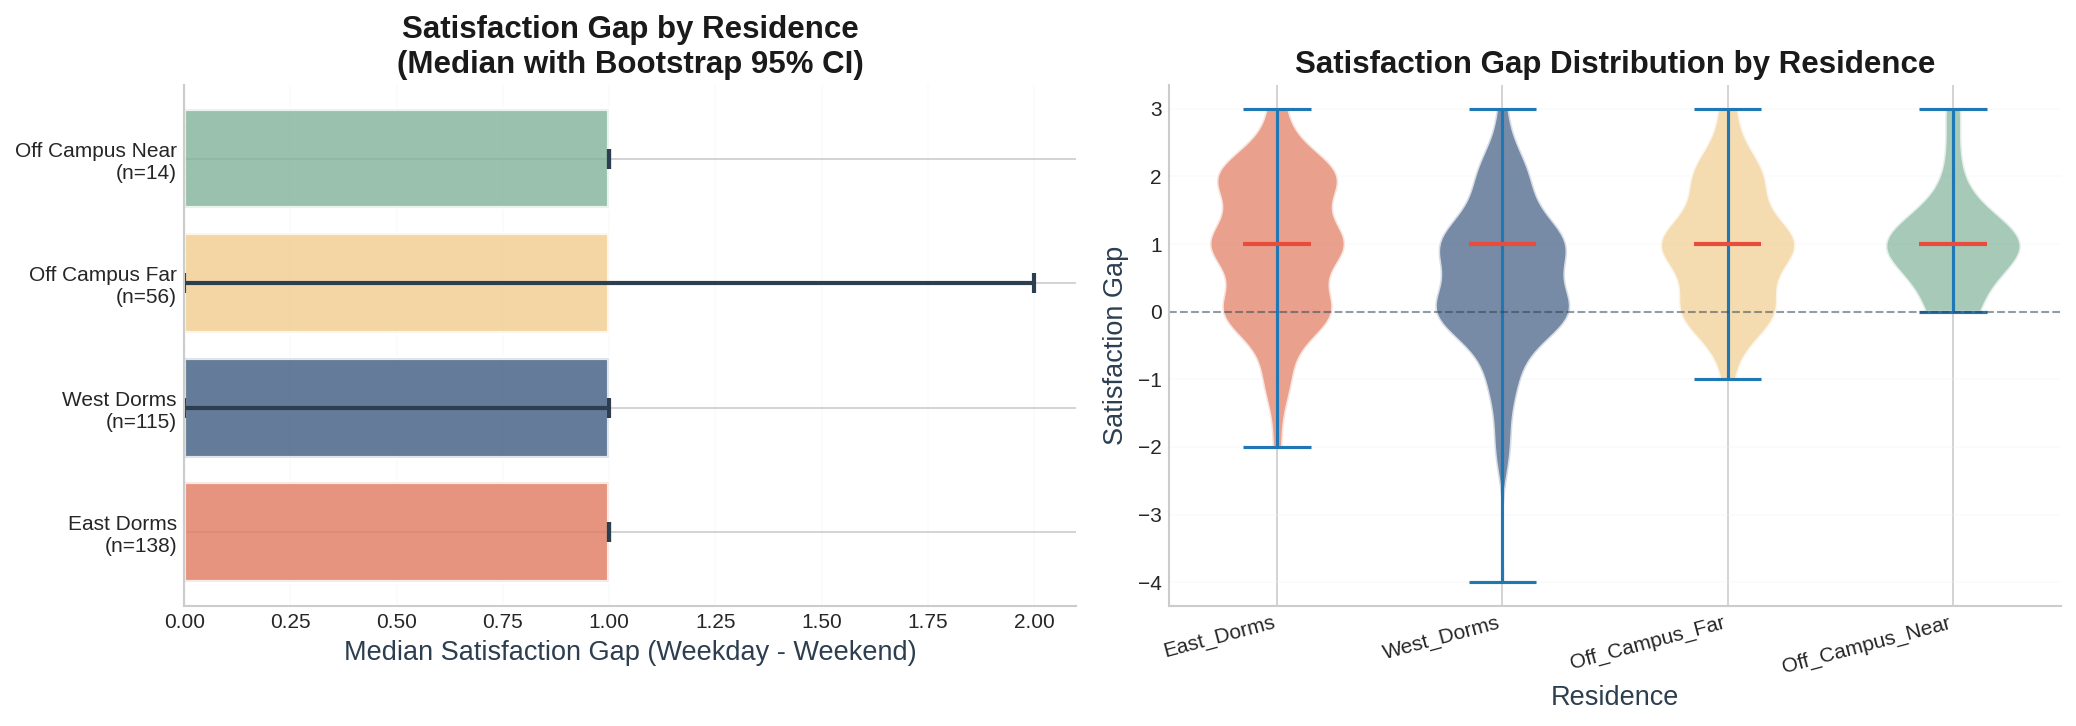

In [13]:
# =============================================================================
# STEP 3: Satisfaction Gap by Residence (NONPARAMETRIC)
# =============================================================================
print("\n" + "="*70)
print("STEP 3: Satisfaction Gap by Residence (Nonparametric Analysis)")
print("="*70)

# Calculate gap statistics by residence (nonparametric)
gap_by_residence = []
gap_groups = []

for residence in valid_residences:
    res_df = df[df['Residence_Simplified'] == residence]
    gap_data = res_df['Satisfaction_Gap'].dropna()
    n = len(gap_data)
    
    # Nonparametric statistics
    median_gap = gap_data.median()
    q25 = gap_data.quantile(0.25)
    q75 = gap_data.quantile(0.75)
    
    # Bootstrap CI for median
    median_ci = bootstrap_median_ci(gap_data, n_bootstrap=1000)
    
    gap_by_residence.append({
        'Residence': residence,
        'n': n,
        'Median_Gap': median_gap,
        'Q25': q25,
        'Q75': q75,
        'CI_Lower': median_ci[0],
        'CI_Upper': median_ci[1]
    })
    
    gap_groups.append(gap_data.values)

gap_table = pd.DataFrame(gap_by_residence)
print("\n3A) Satisfaction Gap by Residence (Nonparametric):")
print(gap_table.round(3))

# PRIMARY TEST: Kruskal-Wallis
h_stat, p_kruskal = kruskal(*gap_groups)

# Effect size: Epsilon-squared
n_total = sum(len(g) for g in gap_groups)
k = len(gap_groups)
epsilon_sq = (h_stat - k + 1) / (n_total - k) if n_total > k else 0

print(f"\n3B) Kruskal-Wallis Test (PRIMARY):")
print(f"  H-statistic: {h_stat:.3f}")
print(f"  p-value: {p_kruskal:.6f}")
print(f"  Epsilon-squared (effect size): {epsilon_sq:.3f}")
print(f"  Interpretation: {'Significant' if p_kruskal < 0.05 else 'Not significant'} difference")

# POST-HOC: Dunn's test with Holm correction
if p_kruskal < 0.05 and len(gap_groups) > 2:
    print("\n3C) Post-hoc Comparisons (Dunn's Test with Holm correction):")
    try:
        # Create data frame for Dunn's test
        gap_data_list = []
        gap_residence_list = []
        for res, gap_vals in zip(valid_residences, gap_groups):
            gap_data_list.extend(gap_vals)
            gap_residence_list.extend([res] * len(gap_vals))
        
        dunn_df = pd.DataFrame({
            'Gap': gap_data_list,
            'Residence': gap_residence_list
        })
        
        # Run Dunn's test
        dunn_results = posthoc_dunn(dunn_df, val_col='Gap', group_col='Residence', p_adjust='holm')
        print(dunn_results.round(4))
    except Exception as e:
        print(f"  Note: Dunn's test not available ({e})")
        print("  Alternative: Pairwise Wilcoxon with Holm correction")

# Plot: Gap by residence (nonparametric)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Median gap with bootstrap CI
ax1 = axes[0]
x_pos = np.arange(len(gap_table))
bar_colors = [get_residence_color(res) for res in gap_table['Residence']]
bars = ax1.barh(x_pos, gap_table['Median_Gap'].values, color=bar_colors, 
                edgecolor='white', linewidth=2, alpha=0.8)

for i, (median, ci_low, ci_high) in enumerate(zip(gap_table['Median_Gap'], 
                                                  gap_table['CI_Lower'], 
                                                  gap_table['CI_Upper'])):
    ax1.errorbar(median, i, xerr=[[median - ci_low], [ci_high - median]], 
                 fmt='none', color=ERROR_BAR_COLOR, capsize=ERROR_BAR_CAP_SIZE, 
                 capthick=2, linewidth=2)

ax1.set_yticks(x_pos)
ax1.set_yticklabels([f'{res.replace("_", " ")}\n(n={n})' for res, n in 
                     zip(gap_table['Residence'], gap_table['n'])], fontsize=10)
ax1.set_xlabel('Median Satisfaction Gap (Weekday - Weekend)', fontsize=13, color=TEXT_COLOR)
ax1.set_title('Satisfaction Gap by Residence\n(Median with Bootstrap 95% CI)', 
              fontweight='bold', fontsize=15, color=TITLE_COLOR)
ax1.axvline(0, color=TEXT_COLOR, linestyle='--', linewidth=1, alpha=0.5)
ax1.grid(axis='x', alpha=GRID_ALPHA, color=GRID_COLOR)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Plot 2: Violin plot (shows distribution better than boxplot)
ax2 = axes[1]
violin_data = [df[df['Residence_Simplified'] == res]['Satisfaction_Gap'].dropna().values 
               for res in gap_table['Residence']]
parts = ax2.violinplot(violin_data, positions=range(len(gap_table)), widths=0.6, 
                       showmeans=False, showmedians=True)

# Color violins
for i, (pc, res) in enumerate(zip(parts['bodies'], gap_table['Residence'])):
    pc.set_facecolor(get_residence_color(res))
    pc.set_alpha(0.7)
    pc.set_edgecolor('white')
    pc.set_linewidth(1.5)

# Style median line (FIXED: handle LineCollection properly)
if 'cmedians' in parts:
    median_collection = parts['cmedians']
    median_collection.set_color(NEGATIVE_COLOR)
    median_collection.set_linewidth(2)

ax2.axhline(0, color=TEXT_COLOR, linestyle='--', linewidth=1, alpha=0.5)
ax2.set_xticks(range(len(gap_table)))
ax2.set_xticklabels(gap_table['Residence'], rotation=15, ha='right')
ax2.set_ylabel('Satisfaction Gap', fontsize=13, color=TEXT_COLOR)
ax2.set_xlabel('Residence', fontsize=13, color=TEXT_COLOR)
ax2.set_title('Satisfaction Gap Distribution by Residence', 
              fontweight='bold', fontsize=15, color=TITLE_COLOR)
ax2.grid(axis='y', alpha=GRID_ALPHA, color=GRID_COLOR)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()
plt.close()


STEP 3B: Weekday vs Weekend Satisfaction by Residence

3B) Satisfaction by Residence (Median with Bootstrap 95% CI):
         Residence  Weekday_Median  Weekday_CI_Lower  Weekday_CI_Upper  \
0       East_Dorms             3.0               3.0               3.0   
1       West_Dorms             2.0               2.0               3.0   
2   Off_Campus_Far             3.0               2.0               3.0   
3  Off_Campus_Near             2.5               2.0               3.0   

   Weekend_Median  Weekend_CI_Lower  Weekend_CI_Upper    n  
0             2.0               2.0               2.0  138  
1             2.0               2.0               2.0  115  
2             1.0               1.0               2.0   56  
3             1.5               1.0               2.0   14  


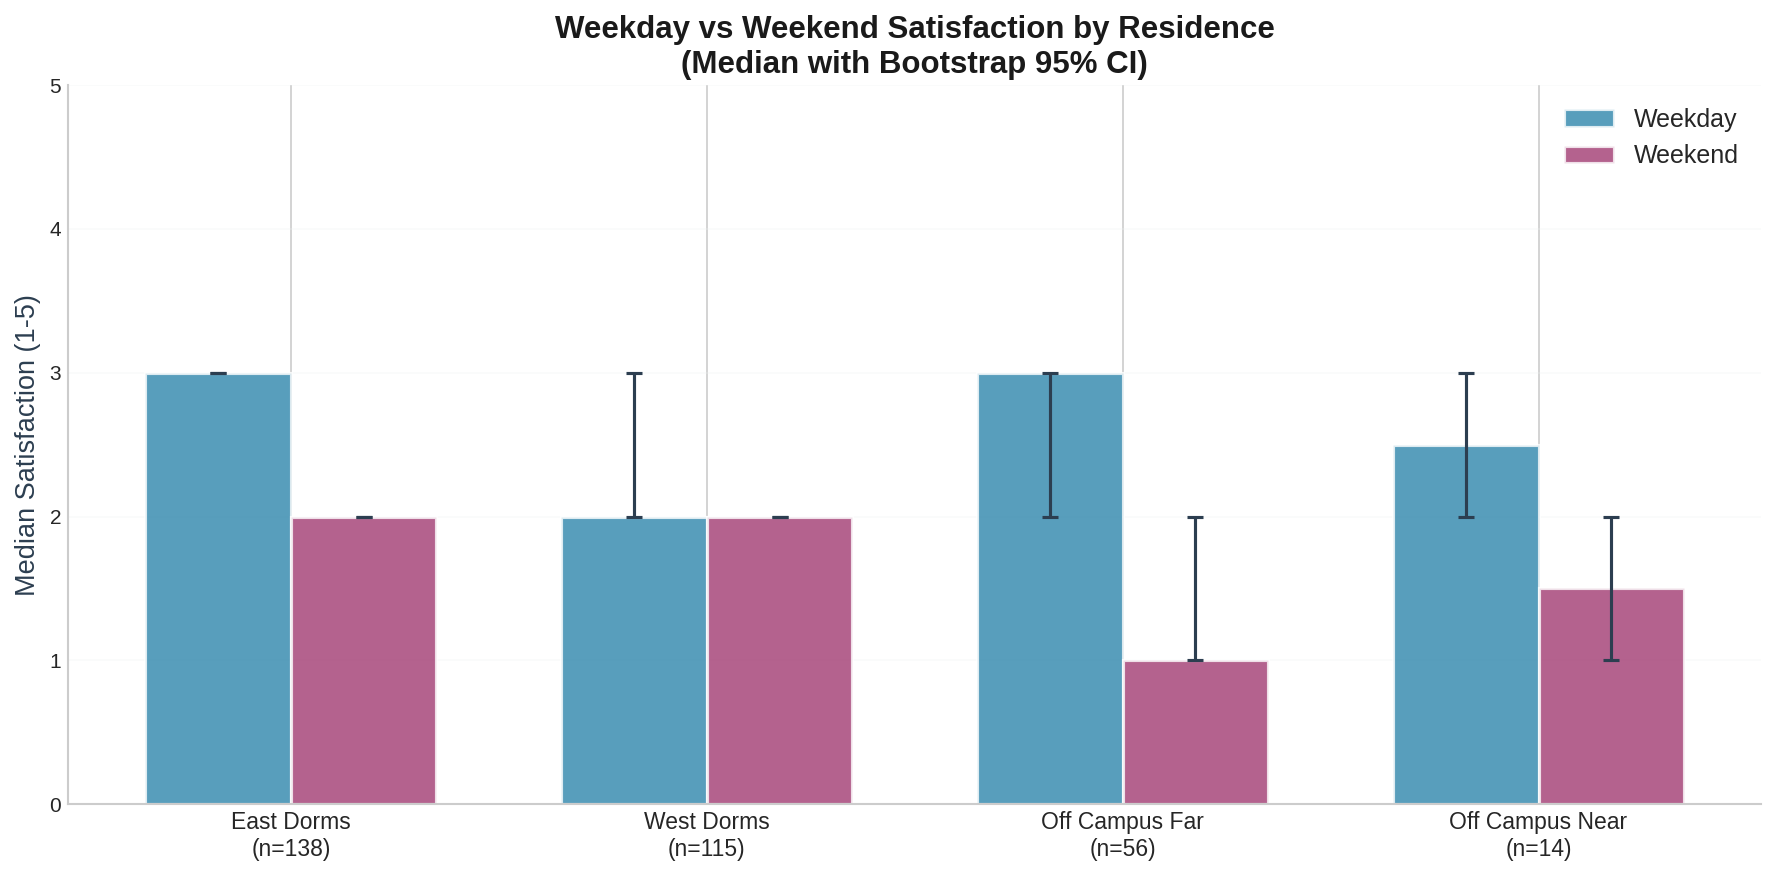

In [14]:
# =============================================================================
# STEP 3B: Weekday vs Weekend Satisfaction by Residence (Two-Way Plot)
# =============================================================================
print("\n" + "="*70)
print("STEP 3B: Weekday vs Weekend Satisfaction by Residence")
print("="*70)

# Calculate medians and bootstrap CIs by residence
residence_satisfaction_data = []

for residence in valid_residences:
    res_df = df[df['Residence_Simplified'] == residence]
    
    # Weekday
    wd_data = res_df['Weekday_Schedule_Satisfaction'].dropna()
    wd_median = wd_data.median()
    wd_ci = bootstrap_median_ci(wd_data, n_bootstrap=2000)
    
    # Weekend
    we_data = res_df['Weekend_Schedule_Satisfaction'].dropna()
    we_median = we_data.median()
    we_ci = bootstrap_median_ci(we_data, n_bootstrap=2000)
    
    residence_satisfaction_data.append({
        'Residence': residence,
        'Weekday_Median': wd_median,
        'Weekday_CI_Lower': wd_ci[0],
        'Weekday_CI_Upper': wd_ci[1],
        'Weekend_Median': we_median,
        'Weekend_CI_Lower': we_ci[0],
        'Weekend_CI_Upper': we_ci[1],
        'n': len(wd_data)
    })

res_sat_table = pd.DataFrame(residence_satisfaction_data)
print("\n3B) Satisfaction by Residence (Median with Bootstrap 95% CI):")
print(res_sat_table.round(3))

# Plot: Weekday vs Weekend by Residence
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(valid_residences))
width = 0.35

# Weekday bars
wd_medians = [res_sat_table[res_sat_table['Residence'] == res]['Weekday_Median'].values[0] 
              for res in valid_residences]
wd_ci_lowers = [res_sat_table[res_sat_table['Residence'] == res]['Weekday_CI_Lower'].values[0] 
                for res in valid_residences]
wd_ci_uppers = [res_sat_table[res_sat_table['Residence'] == res]['Weekday_CI_Upper'].values[0] 
                for res in valid_residences]

bars_wd = ax.bar(x - width/2, wd_medians, width, label='Weekday', 
                color=WEEKDAY_COLOR, edgecolor='white', linewidth=1.5, alpha=0.8)
ax.errorbar(x - width/2, wd_medians, yerr=[np.array(wd_medians) - np.array(wd_ci_lowers),
                                           np.array(wd_ci_uppers) - np.array(wd_medians)],
            fmt='none', color=ERROR_BAR_COLOR, capsize=4, capthick=1.5, linewidth=1.5)

# Weekend bars
we_medians = [res_sat_table[res_sat_table['Residence'] == res]['Weekend_Median'].values[0] 
              for res in valid_residences]
we_ci_lowers = [res_sat_table[res_sat_table['Residence'] == res]['Weekend_CI_Lower'].values[0] 
                for res in valid_residences]
we_ci_uppers = [res_sat_table[res_sat_table['Residence'] == res]['Weekend_CI_Upper'].values[0] 
                for res in valid_residences]

bars_we = ax.bar(x + width/2, we_medians, width, label='Weekend', 
                color=WEEKEND_COLOR, edgecolor='white', linewidth=1.5, alpha=0.8)
ax.errorbar(x + width/2, we_medians, yerr=[np.array(we_medians) - np.array(we_ci_lowers),
                                           np.array(we_ci_uppers) - np.array(we_medians)],
            fmt='none', color=ERROR_BAR_COLOR, capsize=4, capthick=1.5, linewidth=1.5)

ax.set_xticks(x)
residence_labels_with_n = [f'{res.replace("_", " ")}\n(n={n})' 
                           for res, n in zip(valid_residences, 
                                            [res_sat_table[res_sat_table['Residence'] == res]['n'].values[0] 
                                             for res in valid_residences])]
ax.set_xticklabels(residence_labels_with_n, fontsize=11)
ax.set_ylabel('Median Satisfaction (1-5)', fontsize=13, color=TEXT_COLOR)
ax.set_title('Weekday vs Weekend Satisfaction by Residence\n(Median with Bootstrap 95% CI)', 
             fontweight='bold', fontsize=15, color=TITLE_COLOR)
ax.legend(fontsize=12)
ax.set_ylim(0, 5)
ax.grid(axis='y', alpha=GRID_ALPHA, color=GRID_COLOR)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()
plt.close()

In [15]:
print(f"\n3B) Kruskal-Wallis Test (PRIMARY):")
print(f"  H-statistic: {h_stat:.3f}")
print(f"  p-value: {p_kruskal:.6f}")
print(f"  Epsilon-squared (effect size): {epsilon_sq:.3f}")
effect_magnitude = interpret_effect_size(epsilon_sq, 'epsilon_squared')
print(f"  Effect magnitude: {effect_magnitude}")
print(f"  Interpretation: {'Significant' if p_kruskal < 0.05 else 'Not significant'} difference with {effect_magnitude} effect size")



3B) Kruskal-Wallis Test (PRIMARY):
  H-statistic: 11.483
  p-value: 0.009381
  Epsilon-squared (effect size): 0.027
  Effect magnitude: small
  Interpretation: Significant difference with small effect size



STEP 4: Problems - Global Ranking (with Wilson CIs)

4A) Problem Ranking (with Wilson 95% CIs):
           Problem  OftenAlways_%  CI_Lower  CI_Upper  Count    n
0      Too Crowded          78.02     73.19     82.19    252  323
1        Long Wait          62.85     57.46     67.94    203  323
2     Not My Route          40.25     35.04     45.68    130  323
3   Hours Mismatch          34.06     29.10     39.38    110  323
4         Late Bus          26.01     21.52     31.05     84  323
5  Route Confusing          19.81     15.83     24.50     64  323
6        Not Clean          14.86     11.40     19.15     48  323
7  Driver Behavior           7.74      5.30     11.18     25  323


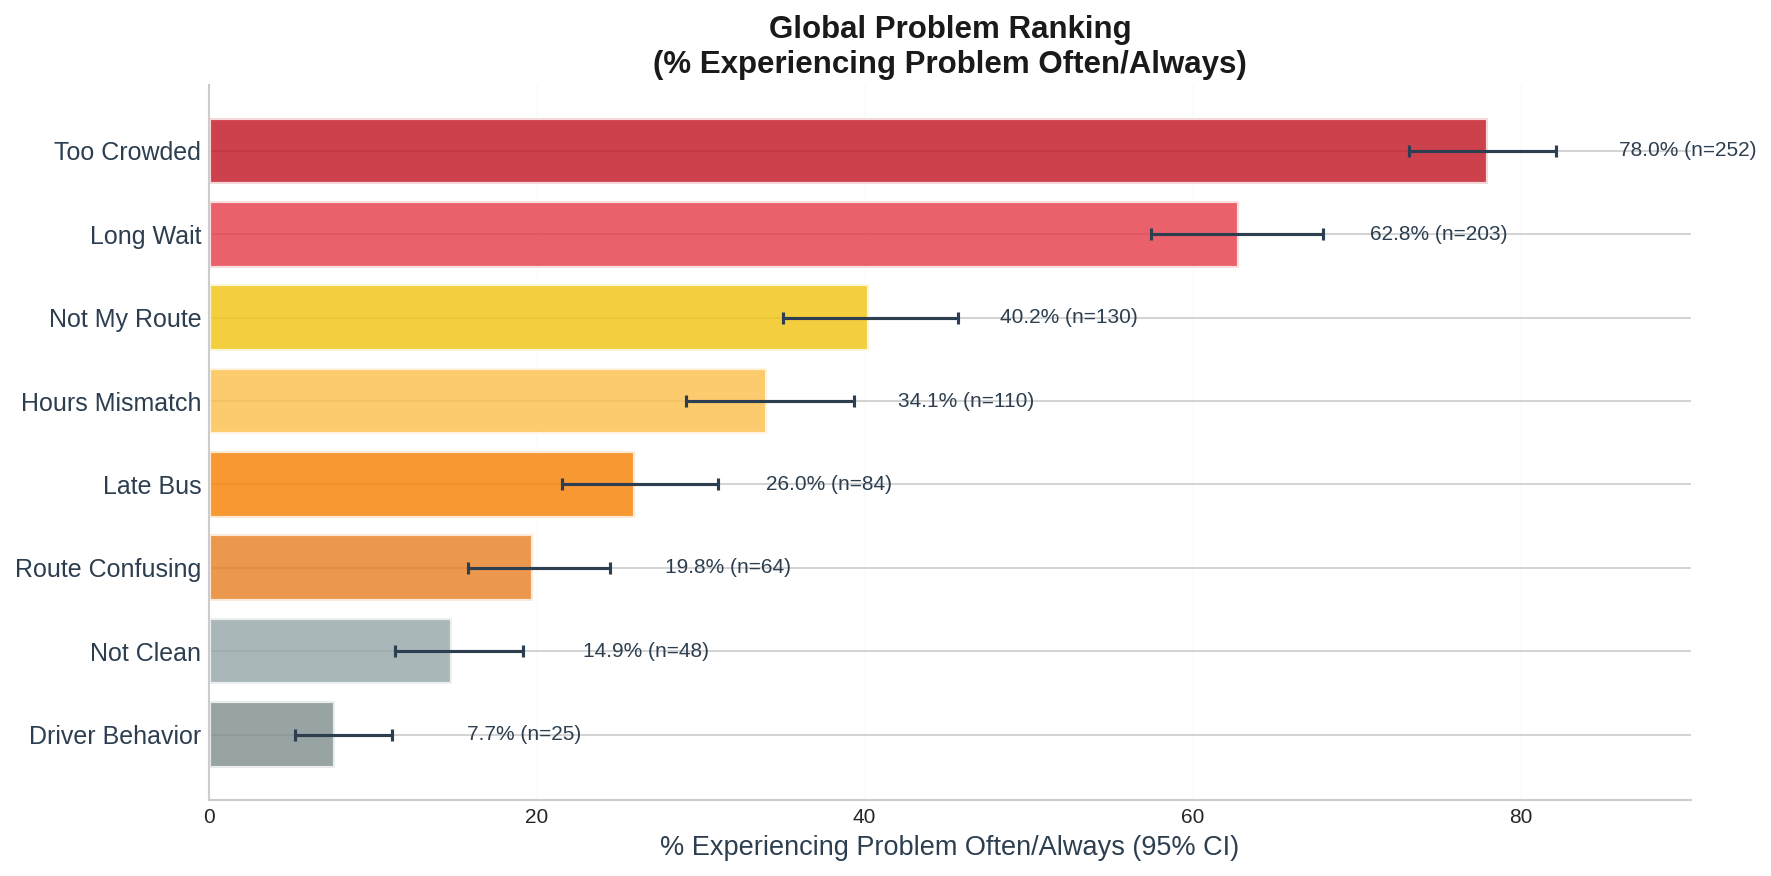

In [16]:
# =============================================================================
# STEP 4: Problems - Global Ranking (WITH WILSON CIs)
# =============================================================================
print("\n" + "="*70)
print("STEP 4: Problems - Global Ranking (with Wilson CIs)")
print("="*70)

problem_vars = ['Problem_TooCrowded', 'Problem_LongWait', 'Problem_NotMyRoute',
                'Problem_HoursMismatch', 'Problem_LateBus', 'Problem_RouteConfusing',
                'Problem_NotClean', 'Problem_DriverBehavior']
problem_labels = ['Too Crowded', 'Long Wait', 'Not My Route', 'Hours Mismatch',
                  'Late Bus', 'Route Confusing', 'Not Clean', 'Driver Behavior']

problem_map = {"Never": 1, "Rarely": 2, "Sometimes": 3, "Often": 4, "Always": 5}

# Calculate statistics with Wilson CIs
problem_stats = []
for var, label in zip(problem_vars, problem_labels):
    if var in df.columns:
        if not pd.api.types.is_numeric_dtype(df[var]):
            var_num = df[var].map(problem_map)
        else:
            var_num = df[var]
        
        valid = var_num.notna().sum()
        often_always = ((var_num >= 4) & (var_num <= 5)).sum()
        pct_often_always = (often_always / valid * 100) if valid > 0 else 0
        
        # Wilson CI for proportion
        if often_always > 0 and often_always < valid:
            ci_lower, ci_upper = proportion_confint(often_always, valid, alpha=0.05, method='wilson')
            ci_lower_pct = ci_lower * 100
            ci_upper_pct = ci_upper * 100
        else:
            ci_lower_pct = 0
            ci_upper_pct = 100
        
        problem_stats.append({
            'Problem': label,
            'OftenAlways_%': pct_often_always,
            'CI_Lower': ci_lower_pct,
            'CI_Upper': ci_upper_pct,
            'Count': often_always,
            'n': valid
        })

problem_ranking = pd.DataFrame(problem_stats).sort_values('OftenAlways_%', ascending=False)
print("\n4A) Problem Ranking (with Wilson 95% CIs):")
print(problem_ranking[['Problem', 'OftenAlways_%', 'CI_Lower', 'CI_Upper', 'Count', 'n']].round(2))

# Plot: Global problem ranking (with error bars)
fig, ax = plt.subplots(figsize=(12, 6))

sorted_problems = problem_ranking.sort_values('OftenAlways_%', ascending=True)
bar_colors = [get_problem_color(prob) for prob in sorted_problems['Problem']]
bars = ax.barh(range(len(sorted_problems)), sorted_problems['OftenAlways_%'].values, 
               color=bar_colors, edgecolor='white', linewidth=2, alpha=0.8)

# Add error bars for CIs
for i, (pct, ci_low, ci_high) in enumerate(zip(sorted_problems['OftenAlways_%'],
                                                 sorted_problems['CI_Lower'],
                                                 sorted_problems['CI_Upper'])):
    ax.errorbar(pct, i, xerr=[[pct - ci_low], [ci_high - pct]], 
                fmt='none', color=ERROR_BAR_COLOR, capsize=3, capthick=1.5, linewidth=1.5)

ax.set_yticks(range(len(sorted_problems)))
ax.set_yticklabels(sorted_problems['Problem'].values, fontsize=12, color=TEXT_COLOR)
ax.set_xlabel('% Experiencing Problem Often/Always (95% CI)', fontsize=13, color=TEXT_COLOR)
ax.set_title('Global Problem Ranking\n(% Experiencing Problem Often/Always)', 
             fontweight='bold', fontsize=15, color=TITLE_COLOR)
ax.set_xlim(0, max(sorted_problems['CI_Upper']) * 1.1)
ax.grid(axis='x', alpha=GRID_ALPHA, color=GRID_COLOR)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add count labels
for i, (pct, count) in enumerate(zip(sorted_problems['OftenAlways_%'], 
                                       sorted_problems['Count'])):
    ax.text(pct + 8, i, f'{pct:.1f}% (n={count})', va='center', fontsize=10, color=TEXT_COLOR)

plt.tight_layout()
plt.show()
plt.close()


STEP 4B: Full Likert Distribution - Top 2 Problems


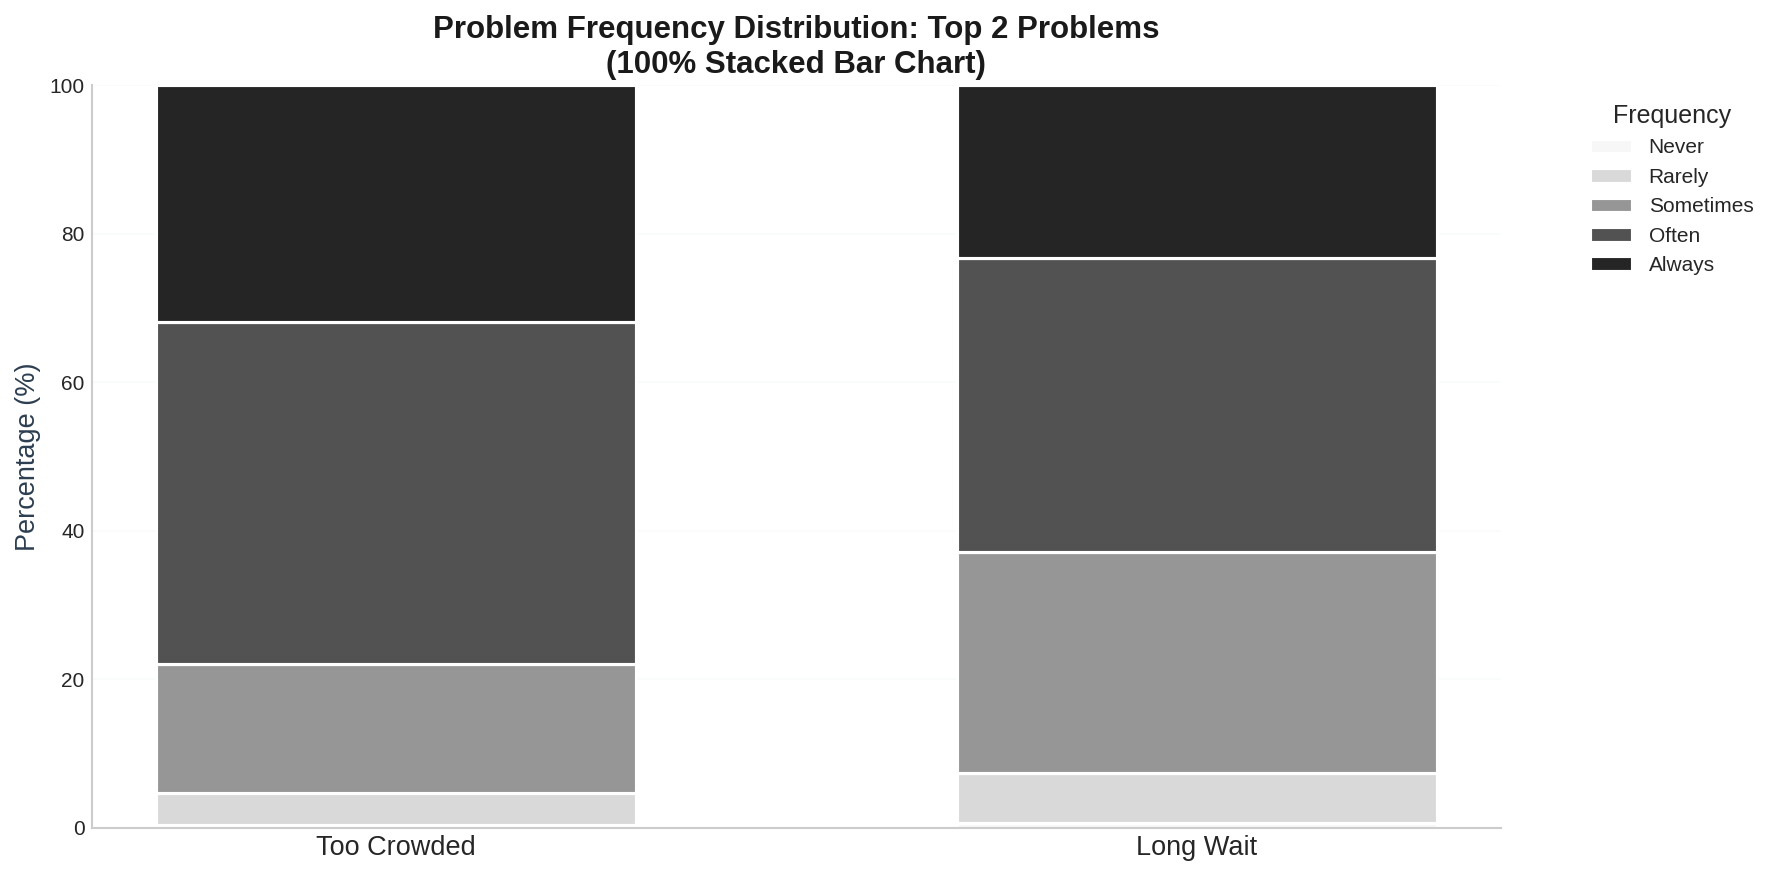

In [17]:
# =============================================================================
# STEP 4B: Stacked Likert Bar Charts for Top 2 Problems
# =============================================================================
print("\n" + "="*70)
print("STEP 4B: Full Likert Distribution - Top 2 Problems")
print("="*70)

problem_vars = ['Problem_TooCrowded', 'Problem_LongWait']
problem_labels = ['Too Crowded', 'Long Wait']
problem_map = {"Never": 1, "Rarely": 2, "Sometimes": 3, "Often": 4, "Always": 5}

# Get distributions for top 2 problems
problem_dists = {}
for var, label in zip(problem_vars, problem_labels):
    if var in df.columns:
        if not pd.api.types.is_numeric_dtype(df[var]):
            var_num = df[var].map(problem_map)
        else:
            var_num = df[var]
        
        counts = var_num.value_counts().sort_index()
        total = counts.sum()
        dist = {}
        for i in range(1, 6):
            dist[i] = counts.get(i, 0) / total * 100
        problem_dists[label] = dist

# Plot: Stacked bar chart for problems
fig, ax = plt.subplots(figsize=(12, 6))

categories_prob = ['Never', 'Rarely', 'Sometimes', 'Often', 'Always']
colors_prob = FREQUENCY_PALETTE
x_pos = np.arange(len(problem_labels))
width = 0.6

for i, prob_label in enumerate(problem_labels):
    bottom = 0
    for j, (cat, color) in enumerate(zip(categories_prob, colors_prob)):
        val = j + 1
        prob_val = problem_dists[prob_label].get(val, 0)
        ax.bar(i, prob_val, width, bottom=bottom, 
               label=cat if i == 0 else '', color=color, edgecolor='white', linewidth=1.5)
        bottom += prob_val

ax.set_xticks(range(len(problem_labels)))
ax.set_xticklabels(problem_labels, fontsize=13)
ax.set_ylabel('Percentage (%)', fontsize=13, color=TEXT_COLOR)
ax.set_title('Problem Frequency Distribution: Top 2 Problems\n(100% Stacked Bar Chart)', 
             fontweight='bold', fontsize=15, color=TITLE_COLOR)
ax.set_ylim(0, 100)
ax.legend(title='Frequency', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax.grid(axis='y', alpha=GRID_ALPHA, color=GRID_COLOR)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()
plt.close()


STEP 5: Problem Severity Index by Residence (Nonparametric)

5A) Problem Severity Index by Residence (Nonparametric):
         Residence    n  Median_PSI    Q25    Q75  CI_Lower  CI_Upper
0       East_Dorms  138       2.750  2.375  3.250     2.625     3.000
1       West_Dorms  115       2.875  2.562  3.375     2.750     3.000
2   Off_Campus_Far   56       2.875  2.625  3.312     2.750     3.125
3  Off_Campus_Near   14       2.875  2.531  3.219     2.500     3.189

5B) Kruskal-Wallis Test (PRIMARY):
  H-statistic: 4.723
  p-value: 0.193276
  Epsilon-squared (effect size): 0.005
  Interpretation: Not significant difference


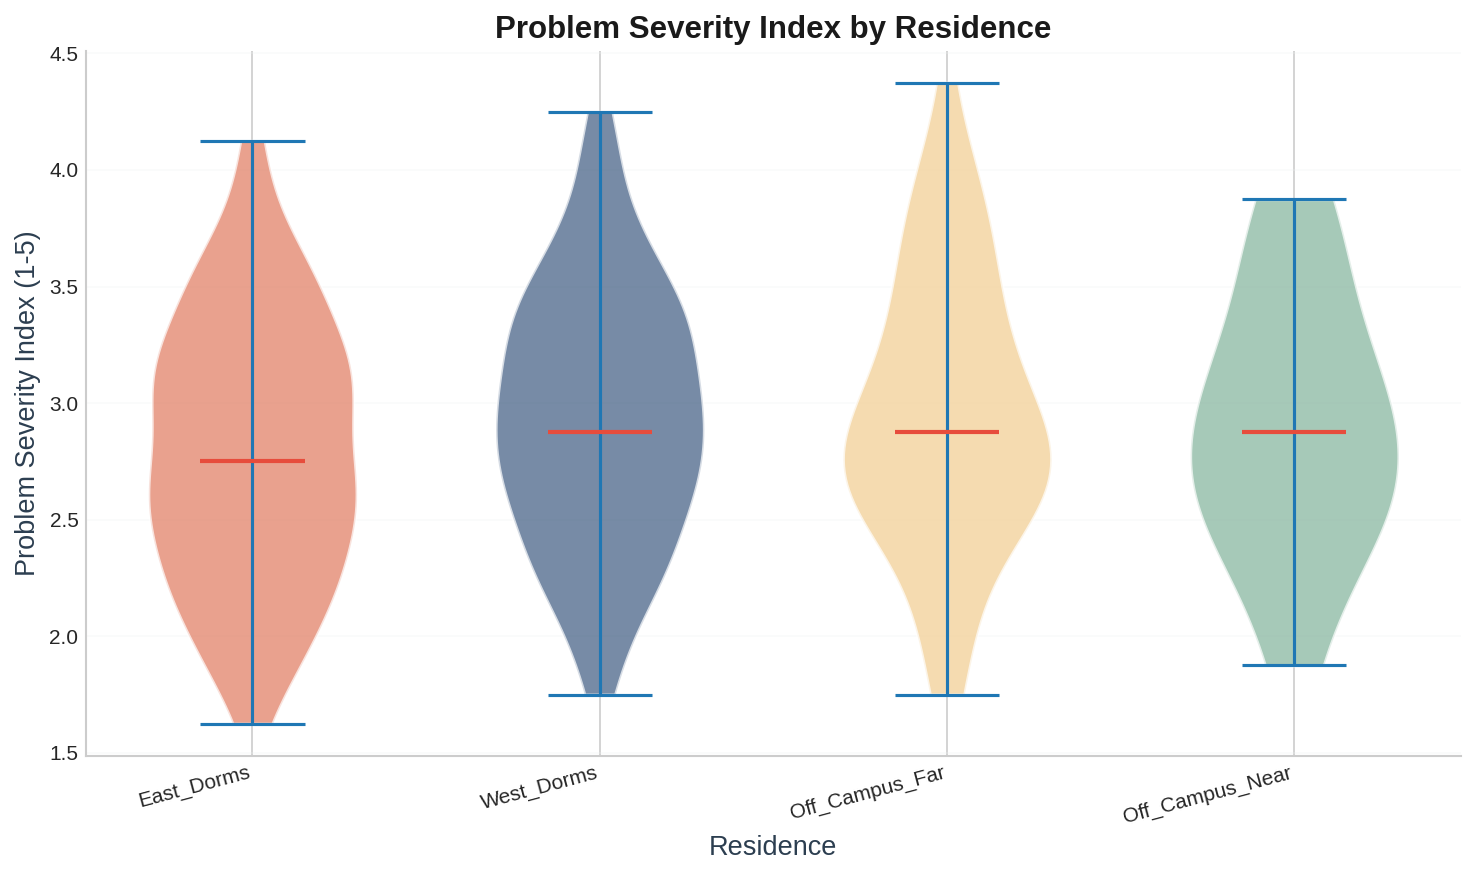

In [18]:
# =============================================================================
# STEP 5: Problem Severity Index by Residence (NONPARAMETRIC)
# =============================================================================
print("\n" + "="*70)
print("STEP 5: Problem Severity Index by Residence (Nonparametric)")
print("="*70)

# Create PSI if not exists
if 'Problem_Severity_Index' not in df.columns:
    problem_cols = [f'Problem_{p}' for p in ['TooCrowded', 'LongWait', 'NotMyRoute',
                                             'HoursMismatch', 'LateBus', 'RouteConfusing',
                                             'NotClean', 'DriverBehavior']]
    
    problem_numeric = pd.DataFrame()
    for col in problem_cols:
        if col in df.columns:
            if not pd.api.types.is_numeric_dtype(df[col]):
                problem_numeric[col] = df[col].map(problem_map)
            else:
                problem_numeric[col] = df[col]
    
    df['Problem_Severity_Index'] = problem_numeric.mean(axis=1)

# Calculate PSI by residence (nonparametric)
psi_by_residence = []
psi_groups = []

for residence in valid_residences:
    res_df = df[df['Residence_Simplified'] == residence]
    psi_data = res_df['Problem_Severity_Index'].dropna()
    n = len(psi_data)
    
    # Nonparametric statistics
    median_psi = psi_data.median()
    q25 = psi_data.quantile(0.25)
    q75 = psi_data.quantile(0.75)
    
    # Bootstrap CI for median
    median_ci = bootstrap_median_ci(psi_data, n_bootstrap=1000)
    
    psi_by_residence.append({
        'Residence': residence,
        'n': n,
        'Median_PSI': median_psi,
        'Q25': q25,
        'Q75': q75,
        'CI_Lower': median_ci[0],
        'CI_Upper': median_ci[1]
    })
    
    psi_groups.append(psi_data.values)

psi_table = pd.DataFrame(psi_by_residence)
print("\n5A) Problem Severity Index by Residence (Nonparametric):")
print(psi_table.round(3))

# PRIMARY TEST: Kruskal-Wallis
h_stat, p_kruskal = kruskal(*psi_groups)

# Effect size: Epsilon-squared
n_total = sum(len(g) for g in psi_groups)
k = len(psi_groups)
epsilon_sq = (h_stat - k + 1) / (n_total - k) if n_total > k else 0

print(f"\n5B) Kruskal-Wallis Test (PRIMARY):")
print(f"  H-statistic: {h_stat:.3f}")
print(f"  p-value: {p_kruskal:.6f}")
print(f"  Epsilon-squared (effect size): {epsilon_sq:.3f}")
print(f"  Interpretation: {'Significant' if p_kruskal < 0.05 else 'Not significant'} difference")

# Plot: PSI by residence (violin plot)
fig, ax = plt.subplots(figsize=(10, 6))

violin_data = [df[df['Residence_Simplified'] == res]['Problem_Severity_Index'].dropna().values 
               for res in valid_residences]
parts = ax.violinplot(violin_data, positions=range(len(valid_residences)), widths=0.6,
                      showmeans=False, showmedians=True)

# Color violins
for i, (pc, res) in enumerate(zip(parts['bodies'], valid_residences)):
    pc.set_facecolor(get_residence_color(res))
    pc.set_alpha(0.7)
    pc.set_edgecolor('white')
    pc.set_linewidth(1.5)

# Style median line (FIXED: handle LineCollection properly)
if 'cmedians' in parts:
    median_collection = parts['cmedians']
    median_collection.set_color(NEGATIVE_COLOR)
    median_collection.set_linewidth(2)

ax.set_xticks(range(len(valid_residences)))
ax.set_xticklabels(valid_residences, rotation=15, ha='right')
ax.set_ylabel('Problem Severity Index (1-5)', fontsize=13, color=TEXT_COLOR)
ax.set_xlabel('Residence', fontsize=13, color=TEXT_COLOR)
ax.set_title('Problem Severity Index by Residence', 
             fontweight='bold', fontsize=15, color=TITLE_COLOR)
ax.grid(axis='y', alpha=GRID_ALPHA, color=GRID_COLOR)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()
plt.close()

In [19]:
# =============================================================================
# STEP 6: Top Problems by Residence (WITH HOLM CORRECTION)
# =============================================================================
print("\n" + "="*70)
print("STEP 6: Top Problem Items by Residence")
print("="*70)

# Ensure df is loaded
if 'df' not in globals():
    df = pd.read_csv('../data/metu_ring_processed.csv')
    # Apply basic setup if needed
    if 'Residence_Simplified' not in df.columns:
        df['Residence'] = df['Residence'].replace(
            'Postgraduate Guesthouse', 
            'West Dorms (Isa Demiray Student Dormitory, 19th Dorm, etc.)'
        )
        def simplify_residence(res):
            if pd.isna(res):
                return 'Unknown'
            if 'East' in str(res):
                return 'East_Dorms'
            elif 'West' in str(res) or 'Isa Demiray' in str(res):
                return 'West_Dorms'
            elif 'within walking' in str(res).lower():
                return 'Off_Campus_Near'
            elif 'far' in str(res).lower():
                return 'Off_Campus_Far'
            else:
                return 'Other'
        df['Residence_Simplified'] = df['Residence'].apply(simplify_residence)
        residence_counts = df['Residence_Simplified'].value_counts()
        valid_residences = residence_counts[residence_counts >= 10].index
        df = df[df['Residence_Simplified'].isin(valid_residences)].copy()

# Define problem variables and labels
problem_vars = ['Problem_TooCrowded', 'Problem_LongWait', 'Problem_NotMyRoute',
                'Problem_HoursMismatch', 'Problem_LateBus', 'Problem_RouteConfusing',
                'Problem_NotClean', 'Problem_DriverBehavior']
problem_labels = ['Too Crowded', 'Long Wait', 'Not My Route', 'Hours Mismatch',
                  'Late Bus', 'Route Confusing', 'Not Clean', 'Driver Behavior']
problem_map = {"Never": 1, "Rarely": 2, "Sometimes": 3, "Often": 4, "Always": 5}

# Select top 2-3 problems (from problem_ranking created in STEP 4)
# If problem_ranking doesn't exist, create it here
if 'problem_ranking' not in globals():
    # Recalculate problem ranking if not available
    problem_stats = []
    for var, label in zip(problem_vars, problem_labels):
        if var in df.columns:
            if not pd.api.types.is_numeric_dtype(df[var]):
                var_num = df[var].map(problem_map)
            else:
                var_num = df[var]
            
            valid = var_num.notna().sum()
            often_always = ((var_num >= 4) & (var_num <= 5)).sum()
            pct_often_always = (often_always / valid * 100) if valid > 0 else 0
            
            problem_stats.append({
                'Problem': label,
                'OftenAlways_%': pct_often_always
            })
    
    problem_ranking = pd.DataFrame(problem_stats).sort_values('OftenAlways_%', ascending=False)

top_problems = problem_ranking.head(3)['Problem'].tolist()
top_problem_vars = [problem_vars[problem_labels.index(p)] for p in top_problems]

print(f"\n6A) Selected Problems: {', '.join(top_problems)}")

# Rest of your code...
# Chi-square tests for each problem (WITH HOLM CORRECTION)
print("\n6B) Chi-square Tests (Residence × Often/Always) with Holm Correction:")


test_results = []
for prob_name, var in zip(top_problems, top_problem_vars):
    # Create binary indicator
    if not pd.api.types.is_numeric_dtype(df[var]):
        df[f'{var}_num'] = df[var].map(problem_map)
    else:
        df[f'{var}_num'] = df[var]
    
    df[f'{var}_OftenAlways'] = ((df[f'{var}_num'] >= 4) & (df[f'{var}_num'] <= 5)).astype(int)
    
    # Contingency table
    contingency = pd.crosstab(df['Residence_Simplified'], df[f'{var}_OftenAlways'])
    
    # Use Fisher's exact if any cell < 5, otherwise Chi-square
    if (contingency < 5).any().any():
        from scipy.stats import fisher_exact
        if contingency.shape == (2, 2):
            oddsratio, p_fisher = fisher_exact(contingency)
            test_name = "Fisher's exact"
            test_stat = oddsratio
        else:
            chi2, p_chi2, dof, expected = chi2_contingency(contingency)
            test_name = "Chi-square (with correction)"
            test_stat = chi2
            p_fisher = p_chi2
    else:
        chi2, p_chi2, dof, expected = chi2_contingency(contingency)
        test_name = "Chi-square"
        test_stat = chi2
        p_fisher = p_chi2
    
    # Cramér's V
    n = contingency.sum().sum()
    cramers_v = np.sqrt(test_stat / (n * (min(contingency.shape) - 1))) if test_stat > 0 else 0
    
    test_results.append({
        'Problem': prob_name,
        'Test': test_name,
        'Statistic': test_stat,
        'p_value': p_fisher,
        'Cramers_V': cramers_v
    })

# Apply Holm correction
test_df = pd.DataFrame(test_results)
rejected, p_corrected, alpha_sidak, alpha_bonf = multipletests(
    test_df['p_value'], alpha=0.05, method='holm'
)

test_df['p_value_holm'] = p_corrected
test_df['Significant'] = rejected

print("\nResults with Holm Correction:")
for _, row in test_df.iterrows():
    print(f"\n  {row['Problem']}:")
    print(f"    Test: {row['Test']}")
    print(f"    Statistic: {row['Statistic']:.3f}")
    print(f"    p-value (uncorrected): {row['p_value']:.6f}")
    print(f"    p-value (Holm corrected): {row['p_value_holm']:.6f}")
    print(f"    Cramér's V: {row['Cramers_V']:.3f}")
    print(f"    {'Significant' if row['Significant'] else 'Not significant'} after Holm correction")


STEP 6: Top Problem Items by Residence

6A) Selected Problems: Too Crowded, Long Wait, Not My Route

6B) Chi-square Tests (Residence × Often/Always) with Holm Correction:

Results with Holm Correction:

  Too Crowded:
    Test: Chi-square (with correction)
    Statistic: 28.820
    p-value (uncorrected): 0.000002
    p-value (Holm corrected): 0.000007
    Cramér's V: 0.299
    Significant after Holm correction

  Long Wait:
    Test: Chi-square (with correction)
    Statistic: 2.725
    p-value (uncorrected): 0.436023
    p-value (Holm corrected): 0.436023
    Cramér's V: 0.092
    Not significant after Holm correction

  Not My Route:
    Test: Chi-square
    Statistic: 17.759
    p-value (uncorrected): 0.000493
    p-value (Holm corrected): 0.000986
    Cramér's V: 0.234
    Significant after Holm correction



6C) Often/Always % by Residence:
Problem          Long Wait  Not My Route  Too Crowded
Residence                                            
East_Dorms            59.4          31.9         64.5
Off_Campus_Far        58.9          30.4         80.4
Off_Campus_Near       71.4          35.7         85.7
West_Dorms            67.8          55.7         92.2


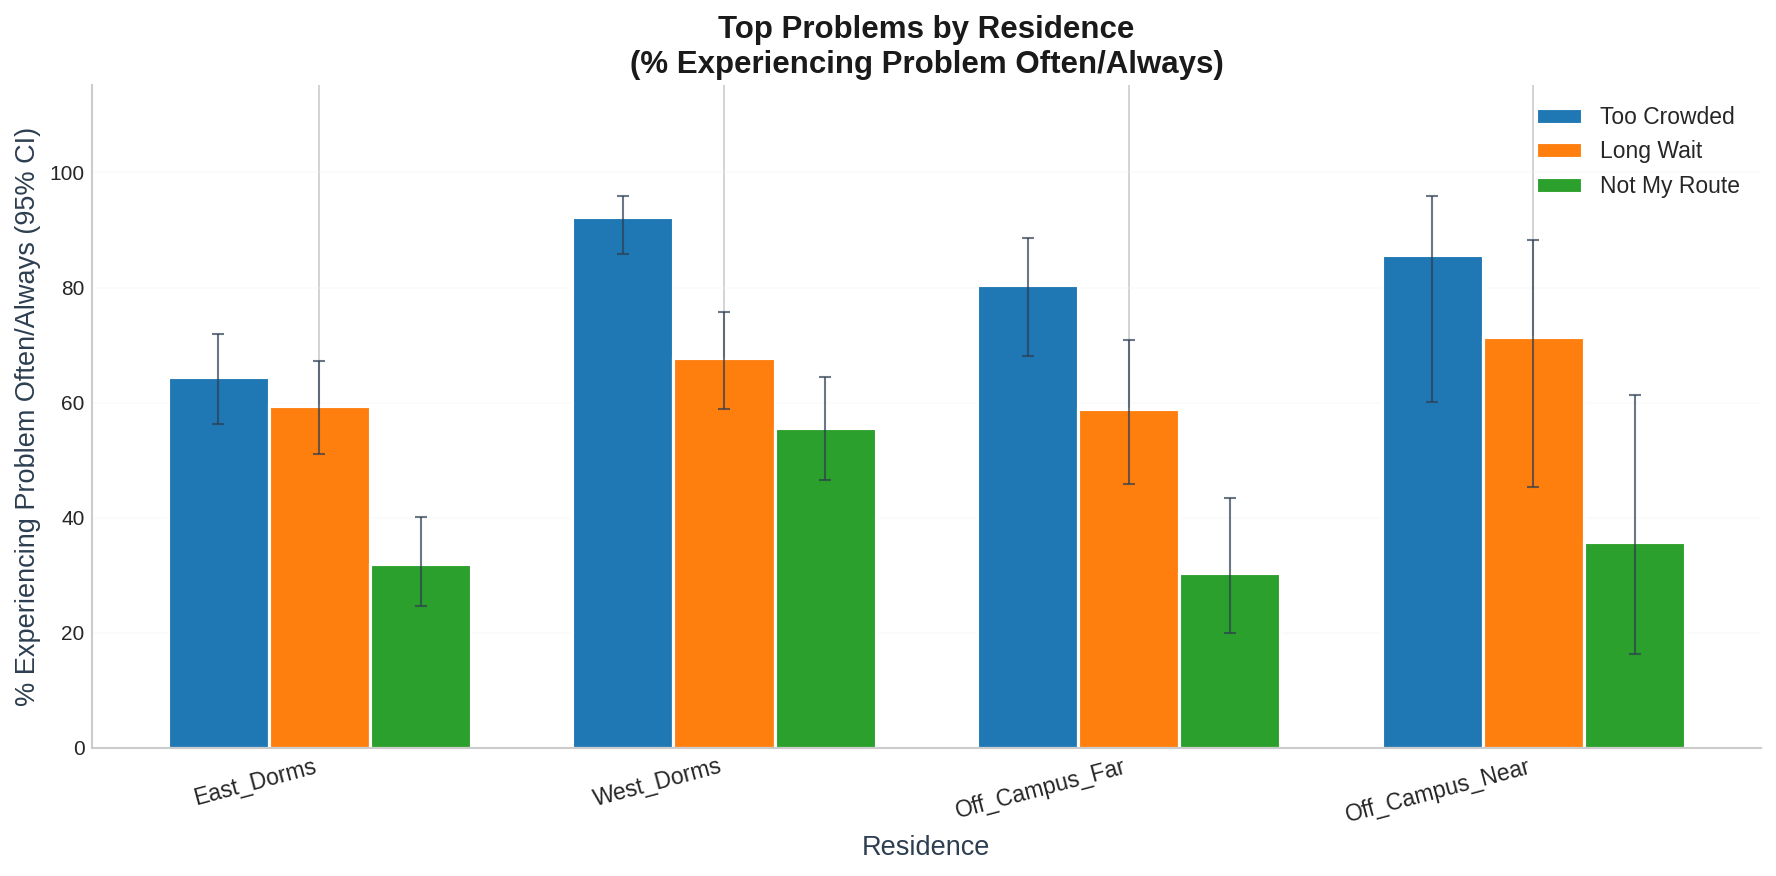

In [20]:
# =============================================================================
# STEP 6: Plot - Top Problems by Residence (Clustered Bar Chart with CIs)
# =============================================================================

# Calculate Often/Always % by residence with Wilson CIs for plotting
problem_residence_data = []
for prob_name, var in zip(top_problems, top_problem_vars):
    for residence in valid_residences:
        res_df = df[df['Residence_Simplified'] == residence]
        if var in res_df.columns:
            if not pd.api.types.is_numeric_dtype(res_df[var]):
                var_num = res_df[var].map(problem_map)
            else:
                var_num = res_df[var]
            
            valid = var_num.notna().sum()
            often_always = ((var_num >= 4) & (var_num <= 5)).sum()
            pct = (often_always / valid * 100) if valid > 0 else 0
            
            # Wilson CI
            ci_lower, ci_upper = proportion_confint(often_always, valid, alpha=0.05, method='wilson')
            ci_lower_pct = ci_lower * 100
            ci_upper_pct = ci_upper * 100
            
            problem_residence_data.append({
                'Problem': prob_name,
                'Residence': residence,
                'OftenAlways_%': pct,
                'CI_Lower': ci_lower_pct,
                'CI_Upper': ci_upper_pct,
                'Count': often_always,
                'n': valid
            })

problem_residence_df = pd.DataFrame(problem_residence_data)
problem_residence_pivot = problem_residence_df.pivot(index='Residence', 
                                                     columns='Problem', 
                                                     values='OftenAlways_%')

print("\n6C) Often/Always % by Residence:")
print(problem_residence_pivot.round(1))

# Plot: Clustered bar chart with CIs
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(valid_residences))
width = 0.25

for i, prob in enumerate(top_problems):
    offset = (i - 1) * width
    values = [problem_residence_df[(problem_residence_df['Problem'] == prob) & 
                                   (problem_residence_df['Residence'] == res)]['OftenAlways_%'].values[0]
              if len(problem_residence_df[(problem_residence_df['Problem'] == prob) & 
                                         (problem_residence_df['Residence'] == res)]) > 0 else 0
              for res in valid_residences]
    ci_lowers = [problem_residence_df[(problem_residence_df['Problem'] == prob) & 
                                      (problem_residence_df['Residence'] == res)]['CI_Lower'].values[0]
                 if len(problem_residence_df[(problem_residence_df['Problem'] == prob) & 
                                            (problem_residence_df['Residence'] == res)]) > 0 else 0
                 for res in valid_residences]
    ci_uppers = [problem_residence_df[(problem_residence_df['Problem'] == prob) & 
                                      (problem_residence_df['Residence'] == res)]['CI_Upper'].values[0]
                 if len(problem_residence_df[(problem_residence_df['Problem'] == prob) & 
                                            (problem_residence_df['Residence'] == res)]) > 0 else 0
                 for res in valid_residences]
    
    bars = ax.bar(x + offset, values, width, label=prob, edgecolor='white', linewidth=1.5)
    # Add error bars
    ax.errorbar(x + offset, values, yerr=[np.array(values) - np.array(ci_lowers),
                                           np.array(ci_uppers) - np.array(values)],
                fmt='none', color=ERROR_BAR_COLOR, capsize=3, capthick=1, linewidth=1, alpha=0.7)

ax.set_ylabel('% Experiencing Problem Often/Always (95% CI)', fontsize=13, color=TEXT_COLOR)
ax.set_xlabel('Residence', fontsize=13, color=TEXT_COLOR)
ax.set_title('Top Problems by Residence\n(% Experiencing Problem Often/Always)', 
             fontweight='bold', fontsize=15, color=TITLE_COLOR)
ax.set_xticks(x)
ax.set_xticklabels(valid_residences, rotation=15, ha='right', fontsize=11)
ax.legend(fontsize=11)
ax.set_ylim(0, max([problem_residence_df['CI_Upper'].max()]) * 1.2)
ax.grid(axis='y', alpha=GRID_ALPHA, color=GRID_COLOR)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()
plt.close()

In [21]:
print(f"\n  {prob_name}:")
print(f"    Test: {test_name}")
print(f"    Statistic: {test_stat:.3f}, p-value: {p_fisher:.6f}")
print(f"    Cramér's V (effect size): {cramers_v:.3f}")
effect_magnitude = interpret_effect_size(cramers_v, 'cramers_v')
print(f"    Effect magnitude: {effect_magnitude}")
print(f"    {'Significant' if p_fisher < 0.05 else 'Not significant'} with {effect_magnitude} effect size")


  Not My Route:
    Test: Chi-square
    Statistic: 17.759, p-value: 0.000493
    Cramér's V (effect size): 0.234
    Effect magnitude: small
    Significant with small effect size


In [22]:
# =============================================================================
# STEP 7: Weighted vs Unweighted Sensitivity (Stratified Bootstrap CIs)
# =============================================================================
print("\n" + "="*70)
print("STEP 7: Weighted vs Unweighted Estimates (with Stratified Bootstrap CIs)")
print("="*70)

def stratified_bootstrap_mean_ci(data, weights, strata, n_bootstrap=5000, confidence=0.95):
    """
    Stratified bootstrap CI for weighted mean.
    Resamples within each stratum, then recomputes weighted estimate.
    """
    bootstrapped_estimates = []
    
    # Get unique strata
    unique_strata = strata.unique()
    
    for _ in range(n_bootstrap):
        # Resample within each stratum
        resampled_indices = []
        for stratum in unique_strata:
            stratum_mask = (strata == stratum)
            stratum_indices = data[stratum_mask].index
            n_stratum = len(stratum_indices)
            if n_stratum > 0:
                # Bootstrap within stratum
                boot_indices = np.random.choice(stratum_indices, size=n_stratum, replace=True)
                resampled_indices.extend(boot_indices)
        
        # Compute weighted estimate on resampled data
        resampled_data = data.loc[resampled_indices]
        resampled_weights = weights.loc[resampled_indices]
        estimate = np.average(resampled_data, weights=resampled_weights)
        bootstrapped_estimates.append(estimate)
    
    alpha = 1 - confidence
    lower = np.percentile(bootstrapped_estimates, 100 * alpha/2)
    upper = np.percentile(bootstrapped_estimates, 100 * (1 - alpha/2))
    mean_est = np.mean(bootstrapped_estimates)
    return mean_est, lower, upper

def stratified_bootstrap_prop_ci(data, weights, strata, n_bootstrap=5000, confidence=0.95):
    """
    Stratified bootstrap CI for weighted proportion.
    """
    bootstrapped_estimates = []
    
    unique_strata = strata.unique()
    
    for _ in range(n_bootstrap):
        resampled_indices = []
        for stratum in unique_strata:
            stratum_mask = (strata == stratum)
            stratum_indices = data[stratum_mask].index
            n_stratum = len(stratum_indices)
            if n_stratum > 0:
                boot_indices = np.random.choice(stratum_indices, size=n_stratum, replace=True)
                resampled_indices.extend(boot_indices)
        
        resampled_data = data.loc[resampled_indices]
        resampled_weights = weights.loc[resampled_indices]
        estimate = np.average(resampled_data, weights=resampled_weights)
        bootstrapped_estimates.append(estimate)
    
    alpha = 1 - confidence
    lower = np.percentile(bootstrapped_estimates, 100 * alpha/2)
    upper = np.percentile(bootstrapped_estimates, 100 * (1 - alpha/2))
    mean_est = np.mean(bootstrapped_estimates)
    return mean_est, lower, upper

# Prepare data for weighting (only include valid strata)
# In STEP 7, before accessing 'Stratum', recreate it:
df_weighted = df[(df['Gender'].isin(['Female', 'Male'])) & 
                 (df['Study_Level_Simplified'].isin(['Undergraduate', 'Graduate']))].copy()

# Recreate Stratum column
df_weighted['Stratum'] = (df_weighted['Gender'].astype(str) + ' × ' + 
                          df_weighted['Study_Level_Simplified'].astype(str))

# 1. Mean Weekday Satisfaction
weekday_data = df_weighted['Weekday_Schedule_Satisfaction'].dropna()
weekday_weights = df_weighted.loc[weekday_data.index, 'Weight']
weekday_strata = df_weighted.loc[weekday_data.index, 'Stratum']

unweighted_wd_mean = weekday_data.mean()
unweighted_wd_se = weekday_data.std() / np.sqrt(len(weekday_data))
unweighted_wd_ci = stats.t.interval(0.95, len(weekday_data)-1, loc=unweighted_wd_mean, scale=unweighted_wd_se)

weighted_wd_mean, weighted_wd_ci_low, weighted_wd_ci_high = stratified_bootstrap_mean_ci(
    weekday_data, weekday_weights, weekday_strata, n_bootstrap=5000
)

# 2. Mean Weekend Satisfaction
weekend_data = df_weighted['Weekend_Schedule_Satisfaction'].dropna()
weekend_weights = df_weighted.loc[weekend_data.index, 'Weight']
weekend_strata = df_weighted.loc[weekend_data.index, 'Stratum']

unweighted_we_mean = weekend_data.mean()
unweighted_we_se = weekend_data.std() / np.sqrt(len(weekend_data))
unweighted_we_ci = stats.t.interval(0.95, len(weekend_data)-1, loc=unweighted_we_mean, scale=unweighted_we_se)

weighted_we_mean, weighted_we_ci_low, weighted_we_ci_high = stratified_bootstrap_mean_ci(
    weekend_data, weekend_weights, weekend_strata, n_bootstrap=5000
)

# 3. Mean PSI
if 'Problem_Severity_Index' not in df_weighted.columns:
    # Create PSI if needed
    problem_cols = [f'Problem_{p}' for p in ['TooCrowded', 'LongWait', 'NotMyRoute',
                                             'HoursMismatch', 'LateBus', 'RouteConfusing',
                                             'NotClean', 'DriverBehavior']]
    problem_map = {"Never": 1, "Rarely": 2, "Sometimes": 3, "Often": 4, "Always": 5}
    problem_numeric = pd.DataFrame()
    for col in problem_cols:
        if col in df_weighted.columns:
            if not pd.api.types.is_numeric_dtype(df_weighted[col]):
                problem_numeric[col] = df_weighted[col].map(problem_map)
            else:
                problem_numeric[col] = df_weighted[col]
    df_weighted['Problem_Severity_Index'] = problem_numeric.mean(axis=1)

psi_data = df_weighted['Problem_Severity_Index'].dropna()
psi_weights = df_weighted.loc[psi_data.index, 'Weight']
psi_strata = df_weighted.loc[psi_data.index, 'Stratum']

unweighted_psi_mean = psi_data.mean()
unweighted_psi_se = psi_data.std() / np.sqrt(len(psi_data))
unweighted_psi_ci = stats.t.interval(0.95, len(psi_data)-1, loc=unweighted_psi_mean, scale=unweighted_psi_se)

weighted_psi_mean, weighted_psi_ci_low, weighted_psi_ci_high = stratified_bootstrap_mean_ci(
    psi_data, psi_weights, psi_strata, n_bootstrap=5000
)

# 4. % Often/Always for Top 2 Problems
problem_map = {"Never": 1, "Rarely": 2, "Sometimes": 3, "Often": 4, "Always": 5}
top_2_problems = ['Problem_TooCrowded', 'Problem_LongWait']
top_2_labels = ['Too Crowded', 'Long Wait']

problem_results = []
for var, label in zip(top_2_problems, top_2_labels):
    if var in df_weighted.columns:
        if not pd.api.types.is_numeric_dtype(df_weighted[var]):
            var_num = df_weighted[var].map(problem_map)
        else:
            var_num = df_weighted[var]
        
        # Binary indicator
        often_always_binary = ((var_num >= 4) & (var_num <= 5)).astype(int)
        problem_data = often_always_binary.dropna()
        problem_weights = df_weighted.loc[problem_data.index, 'Weight']
        problem_strata = df_weighted.loc[problem_data.index, 'Stratum']
        
        unweighted_pct = problem_data.mean() * 100
        unweighted_ci = proportion_confint(problem_data.sum(), len(problem_data), alpha=0.05, method='wilson')
        unweighted_ci_pct = [unweighted_ci[0] * 100, unweighted_ci[1] * 100]
        
        weighted_pct, weighted_ci_low, weighted_ci_high = stratified_bootstrap_prop_ci(
            problem_data, problem_weights, problem_strata, n_bootstrap=5000
        )
        weighted_pct = weighted_pct * 100
        weighted_ci_pct = [weighted_ci_low * 100, weighted_ci_high * 100]
        
        problem_results.append({
            'Problem': label,
            'Unweighted': unweighted_pct,
            'Unweighted_CI': unweighted_ci_pct,
            'Weighted': weighted_pct,
            'Weighted_CI': weighted_ci_pct
        })

# 5. Satisfaction Gap (D = weekday - weekend)
gap_data = df_weighted['Satisfaction_Gap'].dropna()
gap_weights = df_weighted.loc[gap_data.index, 'Weight']
gap_strata = df_weighted.loc[gap_data.index, 'Stratum']

unweighted_gap_median = gap_data.median()
unweighted_gap_ci = bootstrap_median_ci(gap_data, n_bootstrap=2000)

# For weighted gap, compute weighted median using bootstrap
weighted_gap_median, weighted_gap_ci_low, weighted_gap_ci_high = stratified_bootstrap_mean_ci(
    gap_data, gap_weights, gap_strata, n_bootstrap=5000
)

# Create summary table (UPDATED: includes satisfaction gap)
summary_data = {
    'Outcome': [
        'Weekday Satisfaction (median)',
        'Weekend Satisfaction (median)',
        'Satisfaction Gap (median)',
        'Problem Severity Index (mean)',
        f'% Often/Always: {problem_results[0]["Problem"]}',
        f'% Often/Always: {problem_results[1]["Problem"]}'
    ],
    'Unweighted_Estimate': [
        f'{unweighted_wd_mean:.3f}',
        f'{unweighted_we_mean:.3f}',
        f'{unweighted_gap_median:.3f}',
        f'{unweighted_psi_mean:.3f}',
        f'{problem_results[0]["Unweighted"]:.1f}%',
        f'{problem_results[1]["Unweighted"]:.1f}%'
    ],
    'Unweighted_95CI': [
        f'[{unweighted_wd_ci[0]:.3f}, {unweighted_wd_ci[1]:.3f}]',
        f'[{unweighted_we_ci[0]:.3f}, {unweighted_we_ci[1]:.3f}]',
        f'[{unweighted_gap_ci[0]:.3f}, {unweighted_gap_ci[1]:.3f}]',
        f'[{unweighted_psi_ci[0]:.3f}, {unweighted_psi_ci[1]:.3f}]',
        f'[{problem_results[0]["Unweighted_CI"][0]:.1f}, {problem_results[0]["Unweighted_CI"][1]:.1f}]%',
        f'[{problem_results[1]["Unweighted_CI"][0]:.1f}, {problem_results[1]["Unweighted_CI"][1]:.1f}]%'
    ],
    'Weighted_Estimate': [
        f'{weighted_wd_mean:.3f}',
        f'{weighted_we_mean:.3f}',
        f'{weighted_gap_median:.3f}',
        f'{weighted_psi_mean:.3f}',
        f'{problem_results[0]["Weighted"]:.1f}%',
        f'{problem_results[1]["Weighted"]:.1f}%'
    ],
    'Weighted_95CI_Bootstrap': [
        f'[{weighted_wd_ci_low:.3f}, {weighted_wd_ci_high:.3f}]',
        f'[{weighted_we_ci_low:.3f}, {weighted_we_ci_high:.3f}]',
        f'[{weighted_gap_ci_low:.3f}, {weighted_gap_ci_high:.3f}]',
        f'[{weighted_psi_ci_low:.3f}, {weighted_psi_ci_high:.3f}]',
        f'[{problem_results[0]["Weighted_CI"][0]:.1f}, {problem_results[0]["Weighted_CI"][1]:.1f}]%',
        f'[{problem_results[1]["Weighted_CI"][0]:.1f}, {problem_results[1]["Weighted_CI"][1]:.1f}]%'
    ]
}

summary_table = pd.DataFrame(summary_data)
print("\n7A) Weighted vs Unweighted Estimates (with Bootstrap 95% CIs):")
print(summary_table.to_string(index=False))

# Calculate differences (UPDATED: includes satisfaction gap)
print("\n7B) Difference (Weighted - Unweighted):")
differences = {
    'Weekday Satisfaction': weighted_wd_mean - unweighted_wd_mean,
    'Weekend Satisfaction': weighted_we_mean - unweighted_we_mean,
    'Satisfaction Gap': weighted_gap_median - unweighted_gap_median,
    'PSI': weighted_psi_mean - unweighted_psi_mean,
    f'{problem_results[0]["Problem"]}': problem_results[0]["Weighted"] - problem_results[0]["Unweighted"],
    f'{problem_results[1]["Problem"]}': problem_results[1]["Weighted"] - problem_results[1]["Unweighted"]
}

for outcome, diff in differences.items():
    print(f"  {outcome}: {diff:+.3f}")

print("\n7C) Interpretation:")
max_diff = max([abs(d) for d in differences.values()])
if max_diff < 0.1:
    print(f"  ✓ Results are robust: maximum difference = {max_diff:.3f}")
    print("  → Weighting does not substantially change conclusions")
else:
    print(f"  ⚠ Results differ: maximum difference = {max_diff:.3f}")
    print("  → Consider reporting both weighted and unweighted estimates")


STEP 7: Weighted vs Unweighted Estimates (with Stratified Bootstrap CIs)

7A) Weighted vs Unweighted Estimates (with Bootstrap 95% CIs):
                      Outcome Unweighted_Estimate Unweighted_95CI Weighted_Estimate Weighted_95CI_Bootstrap
Weekday Satisfaction (median)               2.725  [2.611, 2.838]             2.702          [2.570, 2.831]
Weekend Satisfaction (median)               1.931  [1.829, 2.034]             1.968          [1.826, 2.115]
    Satisfaction Gap (median)               1.000  [1.000, 1.000]             0.734          [0.562, 0.892]
Problem Severity Index (mean)               2.886  [2.821, 2.951]             2.882          [2.802, 2.961]
  % Often/Always: Too Crowded               77.4%   [72.4, 81.7]%             77.7%           [72.9, 82.3]%
    % Often/Always: Long Wait               62.3%   [56.7, 67.5]%             62.9%           [57.0, 68.7]%

7B) Difference (Weighted - Unweighted):
  Weekday Satisfaction: -0.022
  Weekend Satisfaction: +0.037
  S